In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from k_means import run_kmeans

### Patrones horarios


🔍 Entrenando K-Means con K = 3 clusters...


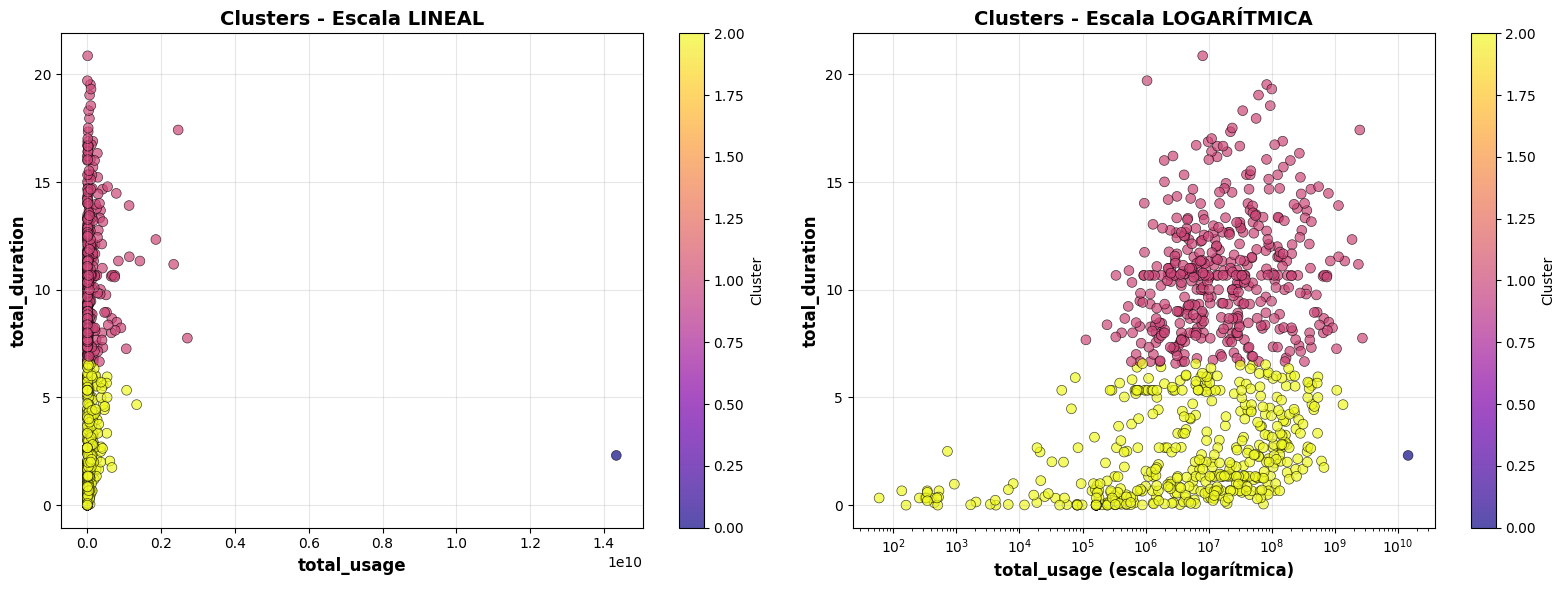

Resumen del día (00–08):
                 total_usage  total_duration  user_count  usage_percent
perfil_consumo                                                         
Alto            1.433565e+10        2.309444           1          16.91
Bajo            2.497508e+10     1033.895000         451          29.45
Normal          4.548735e+10     4649.105278         430          53.64


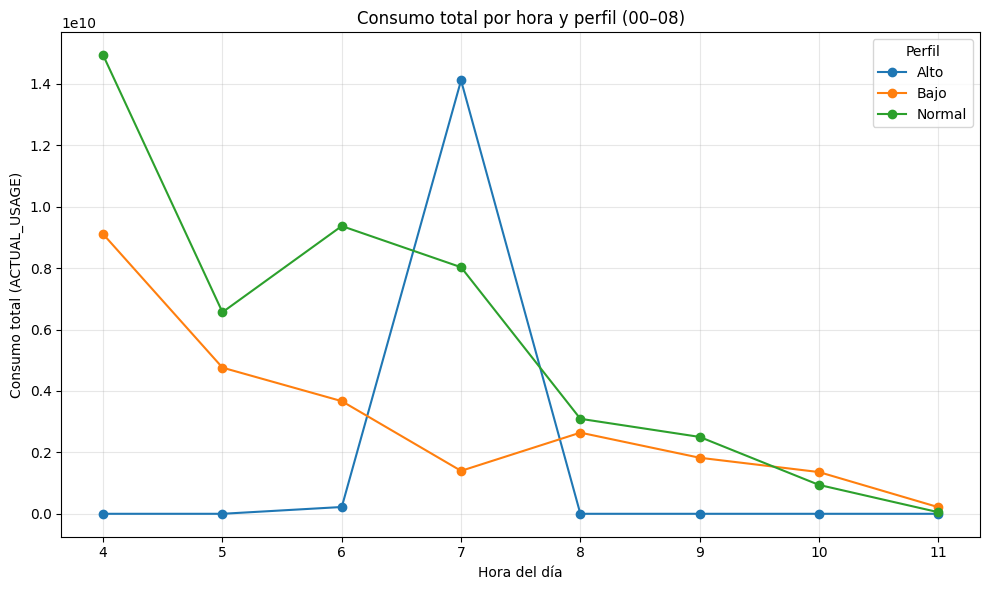

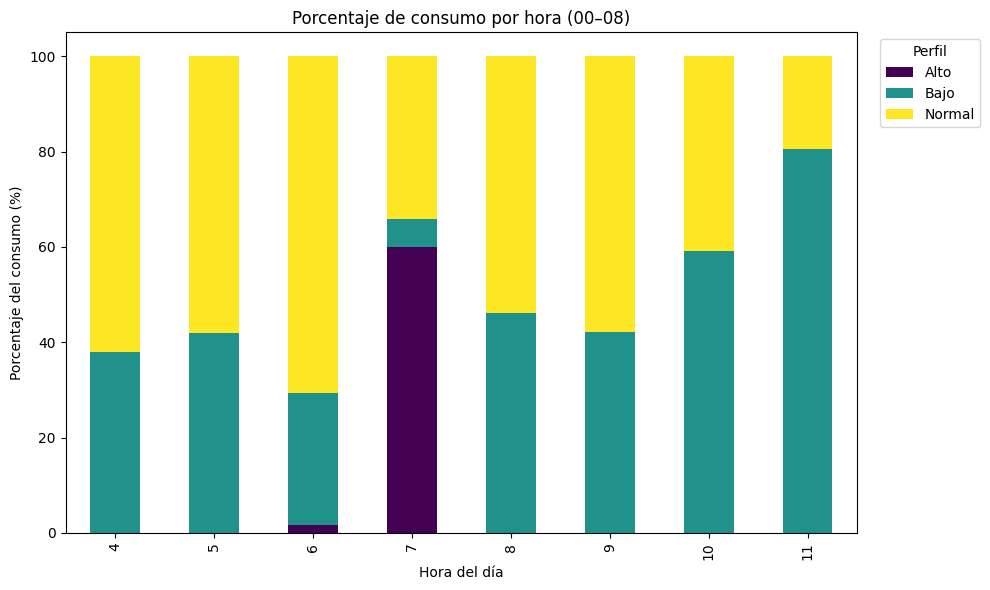

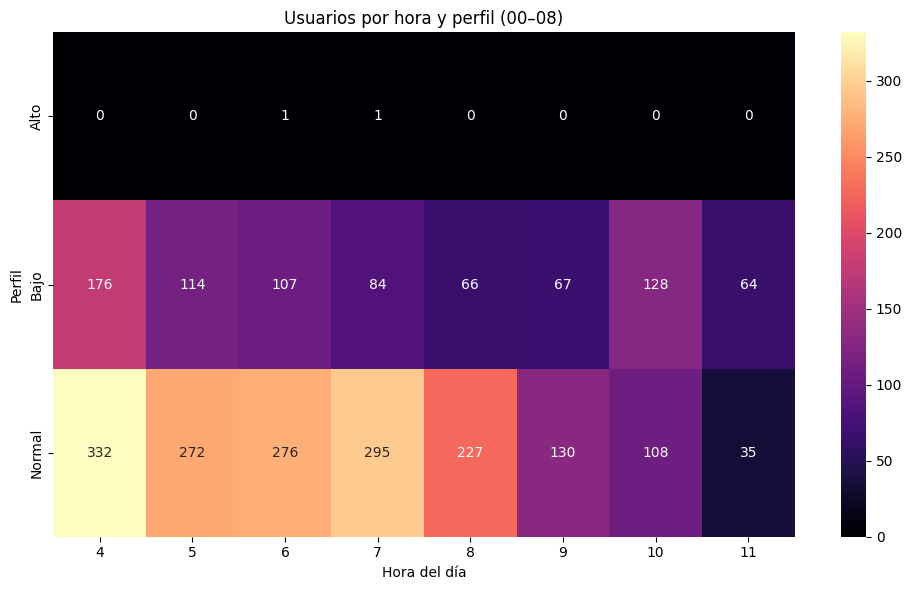

In [6]:
# 1) Cargar dataset
df = pd.read_csv("../data/synthetic_data/datos_a_completar.csv")

# 2) Convertir fechas a datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])

# 3) Crear columna de duración en horas
df['DURATION_HOURS'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 3600

# 4) Cargar outliers detectados por DBSCAN
# outliers = pd.read_csv("../outliers-analysis/outliers.csv")

# # 5) Quitar outliers del dataset
# df_no_outliers = df[~df.index.isin(outliers.index)].copy()
# df_1 = df_no_outliers
df_1 = df

# 6) AGRUPAR POR USUARIO (OBJ_ID) antes de clustering  # <-- agregado
usuarios = df_1.groupby('OBJ_ID').agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE','count')
).reset_index()

# 7) Ejecutar tu método run_kmeans con las variables agregadas por usuario  # <-- cambiado
result = run_kmeans(usuarios, features=['total_usage','total_duration'])

# 8) Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_stats = result.groupby('cluster_kmeans')['total_usage'].mean().sort_values()  # <-- cambiado (usa total_usage)
orden = cluster_stats.index.tolist()
nombres = {orden[0]:'Bajo', orden[1]:'Normal', orden[2]:'Alto'}
result['perfil_consumo'] = result['cluster_kmeans'].map(nombres)

# 9) VOLVER A UNIR perfiles al dataset original para análisis horario  # <-- agregado
df_1 = df_1.merge(result[['OBJ_ID','perfil_consumo']], on='OBJ_ID', how='left')

# 10) Extraer hora del START_DATE
df_1['hour'] = df_1['START_DATE'].dt.hour

# 11) Agregaciones por hora y perfil (usuarios únicos en vez de filas)  # <-- cambiado
agg = df_1.groupby(['perfil_consumo','hour']).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado: cuenta usuarios únicos
).reset_index()

# 12) Pivot para tablas por hora
usage_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_usage').fillna(0)
duration_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='total_duration').fillna(0)
count_hourly = agg.pivot(index='hour', columns='perfil_consumo', values='user_count').fillna(0)
usage_hourly_pct = usage_hourly.div(usage_hourly.sum(axis=1).replace(0,np.nan), axis=0) * 100

# 13) Resumen total del día (usuarios únicos)  # <-- cambiado
day_summary = df_1.groupby('perfil_consumo').agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    user_count=('OBJ_ID','nunique')   # <-- cambiado
)
total_day_usage = day_summary['total_usage'].sum()
day_summary['usage_percent'] = (day_summary['total_usage']/total_day_usage*100).round(2)

print("Resumen del día (00–08):")
print(day_summary)

# 14) Visualizaciones
usage_hourly.plot(kind='line', marker='o', figsize=(10,6))
plt.title("Consumo total por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Consumo total (ACTUAL_USAGE)")
plt.legend(title="Perfil")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("results/consumo_por_hora_lineas.png", dpi=300)
plt.show()
plt.close()

usage_hourly_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Porcentaje de consumo por hora (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje del consumo (%)")
plt.legend(title="Perfil", bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig("results/consumo_por_hora_porcentaje.png", dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10,6))
sns.heatmap(count_hourly.T, annot=True, fmt=".0f", cmap="magma")
plt.title("Usuarios por hora y perfil (00–08)")
plt.xlabel("Hora del día")
plt.ylabel("Perfil")
plt.tight_layout()
plt.savefig("results/usuarios_por_hora_heatmap.png", dpi=300)
plt.show()
plt.close()

# 15) Guardar reporte interpretado
with open("results/patrones_horarios.txt","w",encoding="utf-8") as f:
    f.write("Resumen del día (00–08):\n")
    for perfil,row in day_summary.iterrows():
        f.write(f"- {perfil}: usuarios={row['user_count']}, consumo_total={row['total_usage']:.2f}, "
                f"duracion_total_h={row['total_duration']:.2f}, participacion_consumo={row['usage_percent']:.2f}%\n")
    f.write("\nHallazgos por hora:\n")
    for h in sorted(usage_hourly.index):
        total_h = usage_hourly.loc[h].sum()
        f.write(f"Hora {h:02d}: consumo_total={total_h:.2f}\n")
        top_perfil = usage_hourly.loc[h].idxmax()
        top_val = usage_hourly.loc[h].max()
        f.write(f"  - Perfil dominante: {top_perfil} ({top_val:.2f})\n")
        for perfil in usage_hourly.columns:
            pct = usage_hourly_pct.loc[h, perfil]
            if not np.isnan(pct):
                f.write(f"  - {perfil}: {pct:.2f}% del consumo\n")
        counts = count_hourly.loc[h]
        f.write("  - Usuarios por perfil: " + ", ".join([f"{p}: {int(c)}" for p,c in counts.items()]) + "\n\n")


### Consumo vs Duracion

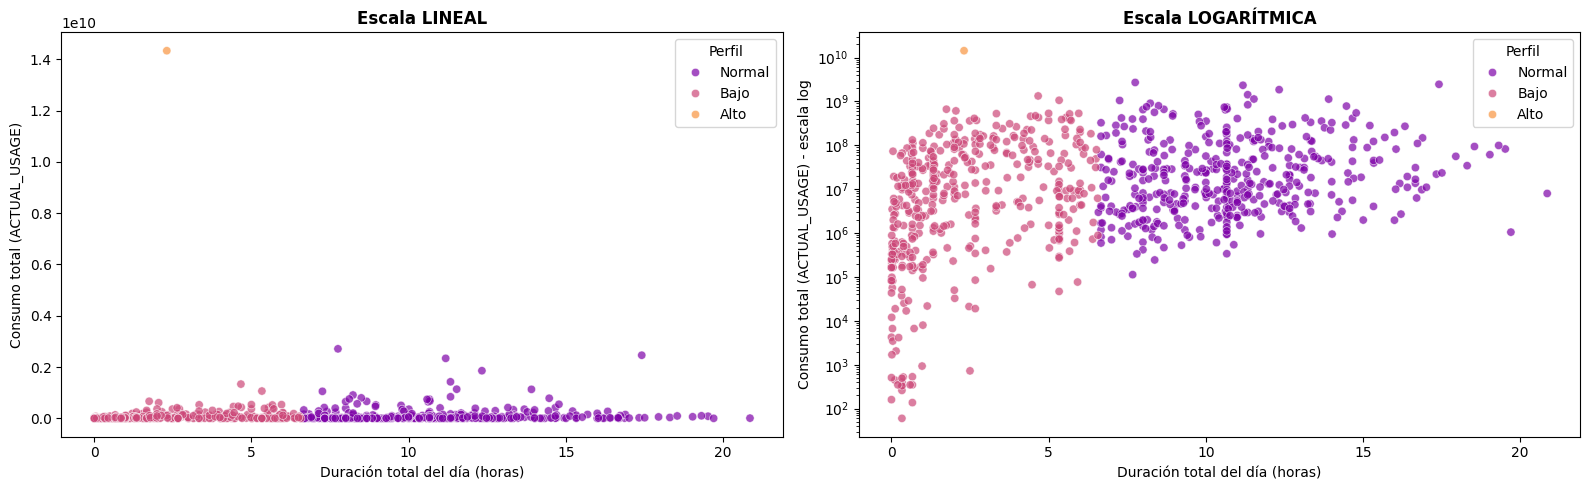

/tmp/ipykernel_124509/4195518299.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')


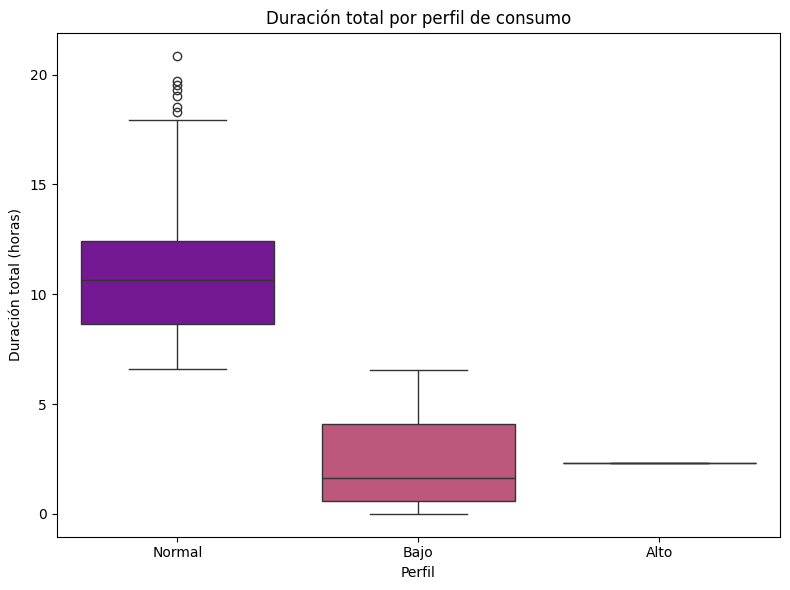

In [7]:
# Scatter plot consumo vs duración: LINEAL vs LOGARÍTMICA
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter LINEAL
sns.scatterplot(
    data=result,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Escala LINEAL", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Duración total del día (horas)")
axes[0].set_ylabel("Consumo total (ACTUAL_USAGE)")
axes[0].legend(title="Perfil", loc='upper right')

# Scatter LOGARÍTMICA
sns.scatterplot(
    data=result,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_yscale('log')
axes[1].set_title("Escala LOGARÍTMICA", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Duración total del día (horas)")
axes[1].set_ylabel("Consumo total (ACTUAL_USAGE) - escala log")
axes[1].legend(title="Perfil", loc='upper right')

plt.tight_layout()
plt.savefig("results/distribucion_consumo_duracion.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Boxplot para comparar duración por perfil
plt.figure(figsize=(8,6))
sns.boxplot(data=result, x='perfil_consumo', y='total_duration', palette='plasma')
plt.title("Duración total por perfil de consumo")
plt.xlabel("Perfil")
plt.ylabel("Duración total (horas)")
plt.tight_layout()
plt.savefig("results/boxplot_duracion_perfil.png", dpi=300)
plt.show()
plt.close()


### Patron de outliers

In [8]:
# 1) Cargar outliers
outliers = pd.read_csv("../outliers-analysis/results/datos/DATOS_outliers.csv")

# 2) Asegurar que las fechas estén en datetime y recalcular duración si es posible
if 'START_DATE' in outliers.columns and 'END_DATE' in outliers.columns:
    outliers['START_DATE'] = pd.to_datetime(outliers['START_DATE'], errors='coerce')
    outliers['END_DATE'] = pd.to_datetime(outliers['END_DATE'], errors='coerce')

    if 'DURATION_HOURS' not in outliers.columns:
        outliers['DURATION_HOURS'] = (outliers['END_DATE'] - outliers['START_DATE']).dt.total_seconds() / 3600

# 3) Si aún no existe DURATION_HOURS, crearla como 0 para evitar KeyError  # <-- agregado
if 'DURATION_HOURS' not in outliers.columns:
    outliers['DURATION_HOURS'] = 0.0

# 4) Agrupar outliers por usuario (usa la columna correcta de ID)  # <-- cambiado
# Verifica si tu CSV usa 'ID' en vez de 'OBJ_ID'
id_col = 'OBJ_ID' if 'OBJ_ID' in outliers.columns else 'ID'

outliers_usuarios = outliers.groupby(id_col).agg(
    total_usage=('ACTUAL_USAGE','sum'),
    total_duration=('DURATION_HOURS','sum'),
    num_sessions=('ACTUAL_USAGE','count')
).reset_index()


### Trafico por cluster

Resumen de participación en el tráfico total:
                 total_usage  total_duration  user_count  usage_percent  \
perfil_consumo                                                            
Alto            1.433565e+10        2.309444           1          16.91   
Bajo            2.497508e+10     1033.895000         451          29.45   
Normal          4.548735e+10     4649.105278         430          53.64   

                usage_per_user  
perfil_consumo                  
Alto              1.433565e+10  
Bajo              5.537712e+07  
Normal            1.057845e+08  


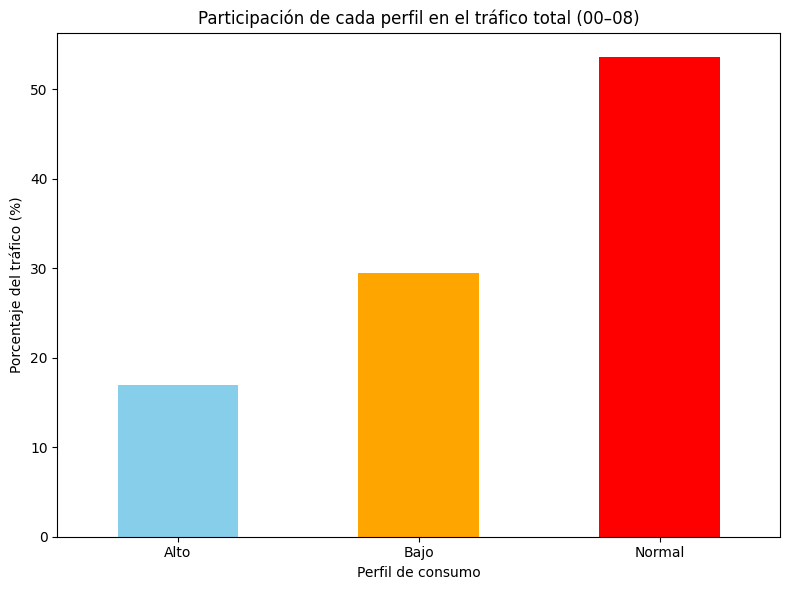

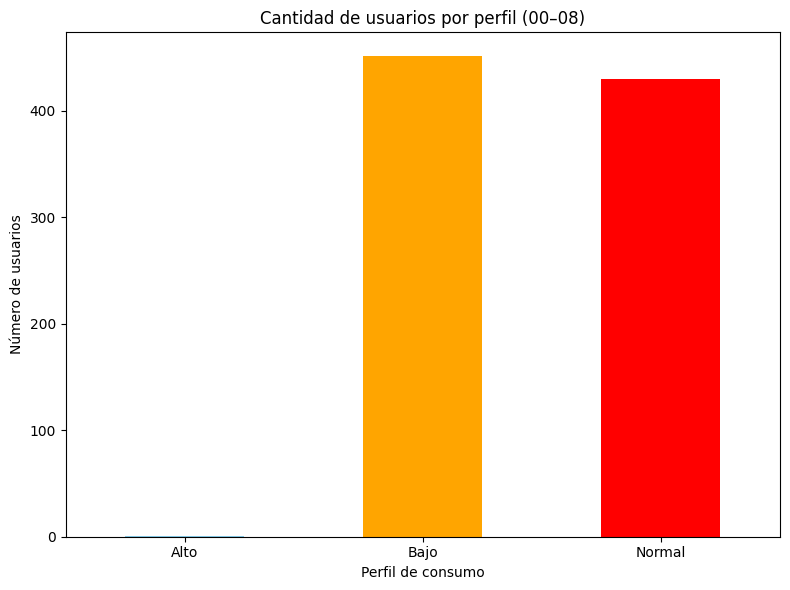

In [9]:
# 1) Resumen por perfil (usa métricas agregadas por usuario)  # <-- cambiado
cluster_summary = result.groupby('perfil_consumo').agg(
    total_usage=('total_usage','sum'),        # <-- cambiado
    total_duration=('total_duration','sum'),  # <-- cambiado
    user_count=('OBJ_ID','nunique')               # <-- cambiado: cuenta usuarios únicos
)

# 2) Porcentaje de tráfico total por cluster
total_usage = cluster_summary['total_usage'].sum()
cluster_summary['usage_percent'] = (cluster_summary['total_usage'] / total_usage * 100).round(2)

# 3) Consumo promedio por usuario en cada cluster
cluster_summary['usage_per_user'] = (cluster_summary['total_usage'] / cluster_summary['user_count']).round(2)

print("Resumen de participación en el tráfico total:")
print(cluster_summary)

# 4) Visualización: participación en el tráfico total
plt.figure(figsize=(8,6))
cluster_summary['usage_percent'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Participación de cada perfil en el tráfico total (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Porcentaje del tráfico (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/participacion_clusters.png", dpi=300)
plt.show()
plt.close()

# 5) Visualización: cantidad de usuarios por perfil
plt.figure(figsize=(8,6))
cluster_summary['user_count'].plot(kind='bar', color=['skyblue','orange','red'])
plt.title("Cantidad de usuarios por perfil (00–08)")
plt.xlabel("Perfil de consumo")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("results/usuarios_por_perfil.png", dpi=300)
plt.show()
plt.close()


### Clustering con reduccion de dimensionalidad

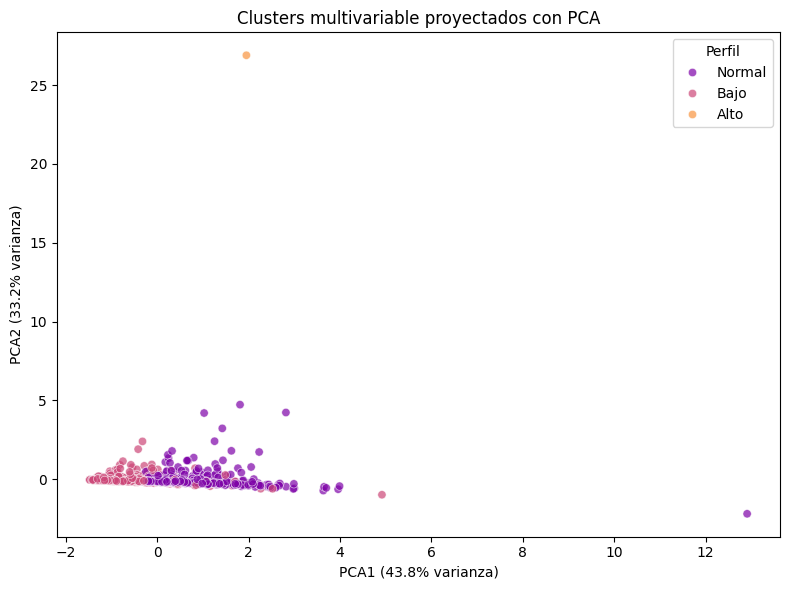

Contribución de cada variable a los componentes principales:
      total_usage  total_duration  num_sessions
PCA1     0.111495        0.704696      0.700694
PCA2     0.992445       -0.042627     -0.115049


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Seleccionar variables adicionales (usa métricas agregadas por usuario)  # <-- cambiado
features = ['total_usage','total_duration','num_sessions']   # <-- cambiado
# Si tienes más columnas relevantes, añádelas aquí, por ejemplo:
# features = ['total_usage','total_duration','num_sessions','VARIABILIDAD_CONSUMO']

X = result[features]   # <-- cambiado

# 2) Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4) Guardar resultados en el DataFrame
result['PCA1'] = X_pca[:,0]
result['PCA2'] = X_pca[:,1]

# 5) Visualización PCA coloreada por perfil
plt.figure(figsize=(8,6))
sns.scatterplot(data=result, x='PCA1', y='PCA2', hue='perfil_consumo', palette='plasma', alpha=0.7)
plt.title("Clusters multivariable proyectados con PCA")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
plt.legend(title="Perfil")
plt.tight_layout()
plt.savefig("results/pca_clusters.png", dpi=300)
plt.show()
plt.close()

# 6) Importancia de cada variable en los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=features, index=['PCA1','PCA2'])
print("Contribución de cada variable a los componentes principales:")
print(pca_components)


### Preferencia de bajos consumidores de datos por otros servicios

A continuació se analizan las preferencias de los bajos consumidores de datos móviles por sservicios de voz y SMS

#### Preferencia por SMS

Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren el uso de mensajes, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de SMS con un 95% se seguridad.

In [11]:
# 1) Cargar muestra.xlsx (datos con TODOS los servicios)
df_completo = pd.read_excel("../data/muestra.xlsx")

# 2) Convertir fechas
df_completo['START_DATE'] = pd.to_datetime(df_completo['START_DATE'])
df_completo['END_DATE'] = pd.to_datetime(df_completo['END_DATE'])
df_completo['DURATION_HOURS'] = (df_completo['END_DATE'] - df_completo['START_DATE']).dt.total_seconds() / 3600

# 3) Ver qué SERVICE_CATEGORY tenemos
print("SERVICE_CATEGORY valores únicos:")
print(df_completo['SERVICE_CATEGORY'].value_counts())
print()

# 4) Datos para DATOS (SERVICE_CATEGORY=5) 
print("PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)")
df_datos = df_completo[df_completo['SERVICE_CATEGORY'] == 5].copy()
print(f"Registros de DATOS: {len(df_datos)}")

usuarios_datos = df_datos.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos']
print(f"Usuarios únicos en DATOS: {len(usuarios_datos)}")
print()

# 5) Datos para SMS (SERVICE_CATEGORY=2)
print("PASO 2: Analizando SMS (SERVICE_CATEGORY=2)")
df_sms = df_completo[df_completo['SERVICE_CATEGORY'] == 2].copy()
print(f"Registros de SMS: {len(df_sms)}")

usuarios_sms = df_sms.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms']
print(f"Usuarios únicos en SMS: {len(usuarios_sms)}")
print()


SERVICE_CATEGORY valores únicos:
SERVICE_CATEGORY
5     7875
2     1551
15     418
1      156
Name: count, dtype: int64

PASO 1: Analizando DATOS (SERVICE_CATEGORY=5)
Registros de DATOS: 7875
Usuarios únicos en DATOS: 881

PASO 2: Analizando SMS (SERVICE_CATEGORY=2)
Registros de SMS: 1551
Usuarios únicos en SMS: 324



In [12]:
# 6) K-MEANS CLUSTERING PARA DATOS usando run_kmeans
print("PASO 3: Clustering en DATOS (K-means)")

# Preparar dataframe con uso de datos por usuario
usuarios_datos_cluster = usuarios_datos[['OWNER_CUST_ID', 'uso_datos']].copy()
usuarios_datos_cluster = usuarios_datos_cluster.rename(columns={'uso_datos': 'total_usage'})

# Aplicar run_kmeans
result_datos = run_kmeans(usuarios_datos_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_datos = result_datos.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_datos = cluster_medias_datos.index.tolist()
mapeo_datos = {orden_datos[0]: 'Bajo', orden_datos[1]: 'Normal', orden_datos[2]: 'Alto'}
result_datos['perfil_datos'] = result_datos['cluster_kmeans'].map(mapeo_datos)

# Volver a unir con OWNER_CUST_ID
result_datos_reset = result_datos.reset_index()
usuarios_datos = result_datos_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_datos']].copy()
usuarios_datos.columns = ['OWNER_CUST_ID', 'uso_datos', 'cluster_datos', 'perfil_datos']

print("\nPerfiles en DATOS:")
print(usuarios_datos.groupby('perfil_datos')['uso_datos'].describe())
print()

# 7) K-MEANS CLUSTERING PARA SMS usando run_kmeans
print("PASO 4: Clustering en SMS (K-means)")

# Preparar dataframe con uso de SMS por usuario
usuarios_sms_cluster = usuarios_sms[['OWNER_CUST_ID', 'uso_sms']].copy()
usuarios_sms_cluster = usuarios_sms_cluster.rename(columns={'uso_sms': 'total_usage'})

# Aplicar run_kmeans
result_sms = run_kmeans(usuarios_sms_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_sms = result_sms.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_sms = cluster_medias_sms.index.tolist()
mapeo_sms = {orden_sms[0]: 'Bajo', orden_sms[1]: 'Normal', orden_sms[2]: 'Alto'}
result_sms['perfil_sms'] = result_sms['cluster_kmeans'].map(mapeo_sms)

# Volver a unir con OWNER_CUST_ID
result_sms_reset = result_sms.reset_index()
usuarios_sms = result_sms_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_sms']].copy()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms', 'cluster_sms', 'perfil_sms']

print("\nPerfiles en SMS:")
print(usuarios_sms.groupby('perfil_sms')['uso_sms'].describe())
print()


PASO 3: Clustering en DATOS (K-means)

🔍 Entrenando K-Means con K = 3 clusters...

Perfiles en DATOS:
              count          mean           std           min           25%  \
perfil_datos                                                                  
Alto            1.0  1.433565e+10           NaN  1.433565e+10  1.433565e+10   
Bajo          857.0  5.188206e+07  9.668568e+07  6.000000e+01  1.801504e+06   
Normal         23.0  1.130413e+09  6.244979e+08  6.098361e+08  7.085935e+08   

                       50%           75%           max  
perfil_datos                                            
Alto          1.433565e+10  1.433565e+10  1.433565e+10  
Bajo          1.004779e+07  4.934920e+07  5.660889e+08  
Normal        8.408796e+08  1.236168e+09  2.710554e+09  

PASO 4: Clustering en SMS (K-means)

🔍 Entrenando K-Means con K = 3 clusters...

Perfiles en SMS:
            count        mean       std    min    25%    50%    75%    max
perfil_sms                                 

In [13]:
# 8) TEST DE HIPÓTESIS: ¿Bajos consumidores de datos prefieren SMS?
# Hipótesis: H0: p <= 0.60 (60% o menos de bajos consumidores de datos son altos/normales en SMS)
# Hipótesis alternativa H1: p > 0.60

print("="*70)
print("TEST DE HIPÓTESIS: PREFERENCIA DE SMS POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en SMS
cruce = usuarios_datos.merge(usuarios_sms, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos = cruce[cruce['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos['perfil_sms'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en SMS
bajos_datos['es_alto_o_normal_sms'] = bajos_datos['perfil_sms'].isin(['Alto', 'Normal'])
count_altos_normales = bajos_datos['es_alto_o_normal_sms'].sum()
proporcion_observada = count_altos_normales / len(bajos_datos) if len(bajos_datos) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en SMS: {count_altos_normales} de {len(bajos_datos)}")
print(f"Proporción observada: {proporcion_observada:.4f} ({proporcion_observada*100:.2f}%)")
print()

# TEST DE PROPORCIÓN CON 95% DE CONFIANZA
# Usando test binomial
from scipy.stats import binomtest
p0 = 0.60  # proporción bajo la hipótesis nula
n = len(bajos_datos)
x = count_altos_normales

# Test unilateral (cola derecha): ¿es la proporción significativamente mayor a 60%?
result_binom = binomtest(x, n, p0, alternative='greater')
pvalue = result_binom.pvalue

print("TEST BINOMIAL (Hipótesis unilateral cola derecha):")
print(f"H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente SMS)")
print(f"H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente SMS)")
print(f"Nivel de significancia: α = 0.05 (confianza 95%)")
print(f"p-value: {pvalue:.6f}")
print()

if pvalue < 0.05:
    print("✅ RESULTADO: RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, la mayoría de bajos consumidores de datos")
    print("   SÍ prefieren SMS (más del 60% son altos/normales en SMS)")
else:
    print("❌ RESULTADO: NO RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de")
    print("   bajos consumidores de datos prefieren SMS")

print()
print("="*70)

# INTERVALO DE CONFIANZA AL 95%
# Intervalo de confianza de Wilson
def wilson_ci(x, n, confidence=0.95):
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = x / n
    denominator = 1 + z**2/n
    centre_adjusted = (p_hat + z**2/(2*n)) / denominator
    adjusted_deviation = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denominator
    return (centre_adjusted - adjusted_deviation, centre_adjusted + adjusted_deviation)

ic_lower, ic_upper = wilson_ci(x, n, 0.95)

print("INTERVALO DE CONFIANZA AL 95% (Método de Wilson):")
print(f"IC: [{ic_lower:.4f}, {ic_upper:.4f}]")
print(f"IC: [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
print()

if ic_lower > 0.60:
    print("✅ El intervalo está completamente por encima de 60%")
    print("   Confirmamos: Más del 60% de bajos consumidores de datos prefieren SMS")
elif ic_upper < 0.60:
    print("❌ El intervalo está completamente por debajo de 60%")
    print("   No se cumple la hipótesis")
else:
    print("⚠️  El intervalo contiene 60%")
    print("   El resultado es borderline/inconcluso")


TEST DE HIPÓTESIS: PREFERENCIA DE SMS POR BAJOS CONSUMIDORES DE DATOS

Total de bajos consumidores de DATOS: 155
Distribución en bajos consumidores de DATOS:
perfil_sms
Bajo      143
Normal     12
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en SMS: 12 de 155
Proporción observada: 0.0774 (7.74%)

TEST BINOMIAL (Hipótesis unilateral cola derecha):
H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente SMS)
H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente SMS)
Nivel de significancia: α = 0.05 (confianza 95%)
p-value: 1.000000

❌ RESULTADO: NO RECHAZAMOS H0
   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de
   bajos consumidores de datos prefieren SMS

INTERVALO DE CONFIANZA AL 95% (Método de Wilson):
IC: [0.0448, 0.1304]
IC: [4.48%, 13.04%]

❌ El intervalo está completamente por debajo de 60%
   No se cumple la hipótesis



TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS
perfil_sms    Bajo  Normal  All
perfil_datos                   
Bajo           143      12  155
All            143      12  155



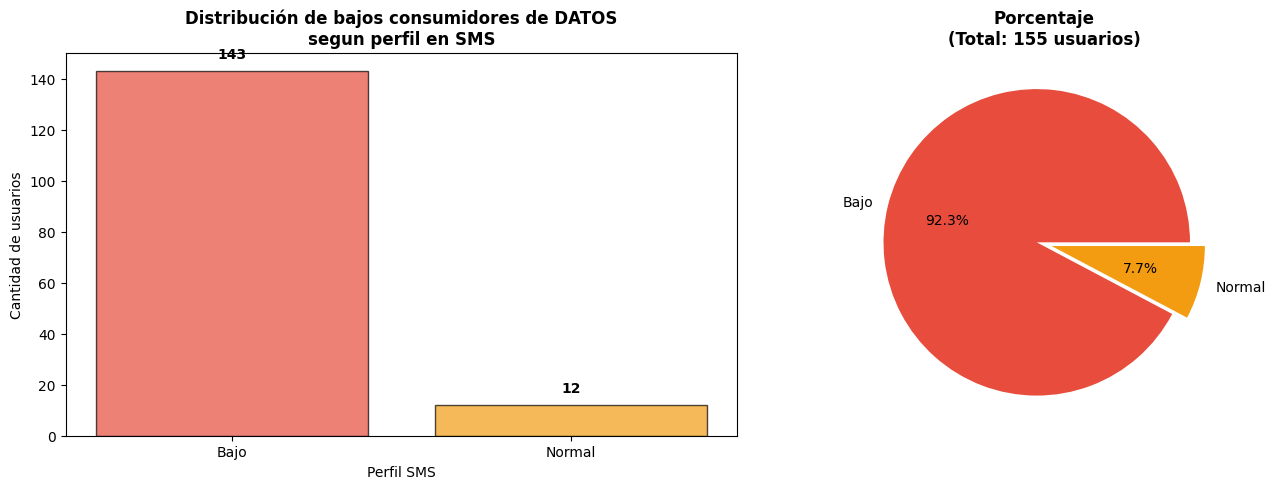

/tmp/ipykernel_124509/2557946786.py:75: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124509/2557946786.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
/home/uhc-312/Code/My_Projects/School/ML-FinalProject/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uhc-312/Code/My_Projects/School/ML-FinalProject/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


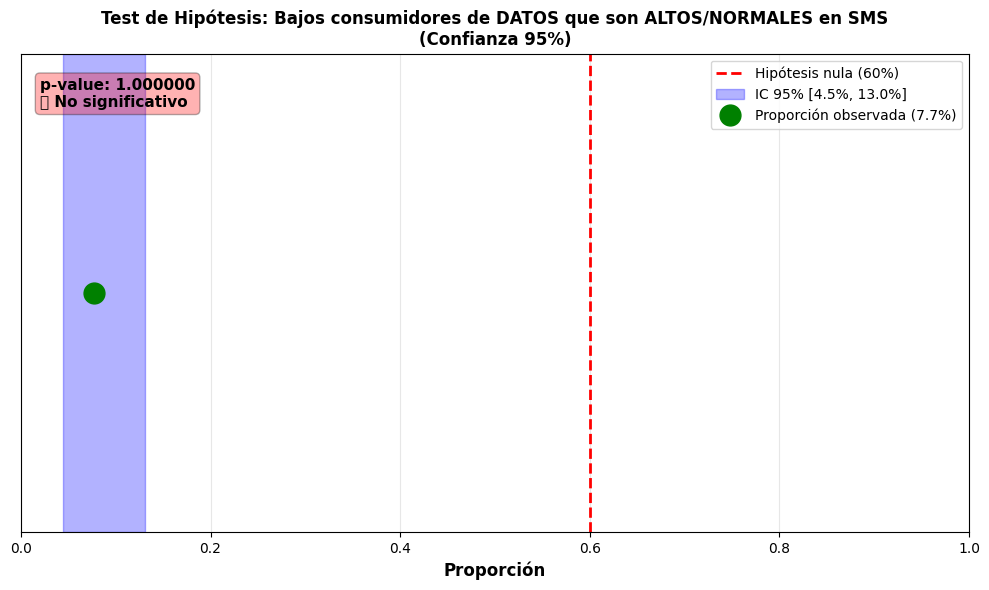

✅ Gráficos guardados en results/


In [14]:
# 8) VISUALIZACIONES DEL TEST

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en SMS")
contingencia = pd.crosstab(
    bajos_datos['perfil_datos'], 
    bajos_datos['perfil_sms'], 
    margins=True
)
print(contingencia)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en SMS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_sms_count = bajos_datos['perfil_sms'].value_counts()
colors_sms = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_sms_count.index]
axes[0].bar(perfiles_sms_count.index, perfiles_sms_count.values, color=colors_sms, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en SMS", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil SMS")
for i, v in enumerate(perfiles_sms_count.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_sms_pct = (bajos_datos['perfil_sms'].value_counts() / len(bajos_datos) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_sms_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_sms_pct.index else 0,
           0.05 if 'Alto' in perfiles_sms_pct.index else 0)
axes[1].pie(perfiles_sms_pct.values, labels=perfiles_sms_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_sms_pct)], explode=explode[:len(perfiles_sms_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_sms.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower, ic_upper, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower*100:.1f}%, {ic_upper*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en SMS\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto = f"p-value: {pvalue:.6f}\n"
if pvalue < 0.05:
    resultado_texto += "✅ Resultado significativo"
    color_resultado = 'green'
else:
    resultado_texto += "❌ No significativo"
    color_resultado = 'red'

ax.text(0.02, 0.95, resultado_texto, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_proporcion.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos guardados en results/")


#### Preferencia de bajos consumidores de datos móviles por las llamadas


Se plantea la hipótesis de que la gran parte de bajos consumidores de datos móviles prefieren las llamadas, es decir, que 60% o más de los consumidores bajos de datos se encuentran entre los consumidores normales o altos de voz con un 95% se seguridad.

In [15]:
# 1) Datos para VOZ (SERVICE_CATEGORY=1)
print("="*70)
print("ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

print("PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)")
df_voz = df_completo[df_completo['SERVICE_CATEGORY'] == 1].copy()
print(f"Registros de VOZ: {len(df_voz)}")

usuarios_voz = df_voz.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz']
print(f"Usuarios únicos en VOZ: {len(usuarios_voz)}")
print()


ANÁLISIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS

PASO 1: Analizando VOZ (SERVICE_CATEGORY=1)
Registros de VOZ: 156
Usuarios únicos en VOZ: 89



In [16]:
# 2) K-MEANS CLUSTERING PARA VOZ usando run_kmeans
print("PASO 2: Clustering en VOZ (K-means)")

# Preparar dataframe con uso de voz por usuario
usuarios_voz_cluster = usuarios_voz[['OWNER_CUST_ID', 'uso_voz']].copy()
usuarios_voz_cluster = usuarios_voz_cluster.rename(columns={'uso_voz': 'total_usage'})

# Aplicar run_kmeans
result_voz = run_kmeans(usuarios_voz_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_voz = result_voz.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_voz = cluster_medias_voz.index.tolist()
mapeo_voz = {orden_voz[0]: 'Bajo', orden_voz[1]: 'Normal', orden_voz[2]: 'Alto'}
result_voz['perfil_voz'] = result_voz['cluster_kmeans'].map(mapeo_voz)

# Volver a unir con OWNER_CUST_ID
result_voz_reset = result_voz.reset_index()
usuarios_voz = result_voz_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_voz']].copy()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz', 'cluster_voz', 'perfil_voz']

print("\nPerfiles en VOZ:")
print(usuarios_voz.groupby('perfil_voz')['uso_voz'].describe())
print()


PASO 2: Clustering en VOZ (K-means)

🔍 Entrenando K-Means con K = 3 clusters...

Perfiles en VOZ:
            count         mean         std     min      25%     50%      75%  \
perfil_voz                                                                     
Alto          1.0  1327.000000         NaN  1327.0  1327.00  1327.0  1327.00   
Bajo         78.0    48.923077   44.768893     0.0    14.50    35.0    60.75   
Normal       10.0   329.400000  125.169396   197.0   242.25   302.5   338.00   

               max  
perfil_voz          
Alto        1327.0  
Bajo         182.0  
Normal       602.0  



In [17]:
# 3) TEST DE HIPÓTESIS: ¿Bajos consumidores de datos prefieren VOZ?
# Hipótesis: H0: p <= 0.60 (60% o menos de bajos consumidores de datos son altos/normales en VOZ)
# Hipótesis alternativa H1: p > 0.60

print("="*70)
print("TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS")
print("="*70)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en VOZ
cruce_voz = usuarios_datos.merge(usuarios_voz, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de datos
bajos_datos_voz = cruce_voz[cruce_voz['perfil_datos'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de DATOS: {len(bajos_datos_voz)}")
print(f"Distribución en bajos consumidores de DATOS:")
print(bajos_datos_voz['perfil_voz'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en VOZ
bajos_datos_voz['es_alto_o_normal_voz'] = bajos_datos_voz['perfil_voz'].isin(['Alto', 'Normal'])
count_altos_normales_voz = bajos_datos_voz['es_alto_o_normal_voz'].sum()
proporcion_observada_voz = count_altos_normales_voz / len(bajos_datos_voz) if len(bajos_datos_voz) > 0 else 0

print(f"Bajos en DATOS que son ALTOS o NORMALES en VOZ: {count_altos_normales_voz} de {len(bajos_datos_voz)}")
print(f"Proporción observada: {proporcion_observada_voz:.4f} ({proporcion_observada_voz*100:.2f}%)")
print()

# TEST DE PROPORCIÓN CON 95% DE CONFIANZA
p0_voz = 0.60  # proporción bajo la hipótesis nula
n_voz = len(bajos_datos_voz)
x_voz = count_altos_normales_voz

# Test unilateral (cola derecha)
result_binom_voz = binomtest(x_voz, n_voz, p0_voz, alternative='greater')
pvalue_voz = result_binom_voz.pvalue

print("TEST BINOMIAL (Hipótesis unilateral cola derecha):")
print(f"H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente VOZ)")
print(f"H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente VOZ)")
print(f"Nivel de significancia: α = 0.05 (confianza 95%)")
print(f"p-value: {pvalue_voz:.6f}")
print()

if pvalue_voz < 0.05:
    print("✅ RESULTADO: RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, la mayoría de bajos consumidores de datos")
    print("   SÍ prefieren VOZ (más del 60% son altos/normales en VOZ)")
else:
    print("❌ RESULTADO: NO RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de")
    print("   bajos consumidores de datos prefieren VOZ")

print()
print("="*70)

# INTERVALO DE CONFIANZA AL 95%
ic_lower_voz, ic_upper_voz = wilson_ci(x_voz, n_voz, 0.95)

print("INTERVALO DE CONFIANZA AL 95% (Método de Wilson):")
print(f"IC: [{ic_lower_voz:.4f}, {ic_upper_voz:.4f}]")
print(f"IC: [{ic_lower_voz*100:.2f}%, {ic_upper_voz*100:.2f}%]")
print()

if ic_lower_voz > 0.60:
    print("✅ El intervalo está completamente por encima de 60%")
    print("   Confirmamos: Más del 60% de bajos consumidores de datos prefieren VOZ")
elif ic_upper_voz < 0.60:
    print("❌ El intervalo está completamente por debajo de 60%")
    print("   No se cumple la hipótesis")
else:
    print("⚠️  El intervalo contiene 60%")
    print("   El resultado es borderline/inconcluso")


TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE DATOS

Total de bajos consumidores de DATOS: 46
Distribución en bajos consumidores de DATOS:
perfil_voz
Bajo      38
Normal     7
Alto       1
Name: count, dtype: int64

Bajos en DATOS que son ALTOS o NORMALES en VOZ: 8 de 46
Proporción observada: 0.1739 (17.39%)

TEST BINOMIAL (Hipótesis unilateral cola derecha):
H0: p ≤ 0.60 (bajos consumidores de datos NO prefieren principalmente VOZ)
H1: p > 0.60 (bajos consumidores de datos SÍ prefieren principalmente VOZ)
Nivel de significancia: α = 0.05 (confianza 95%)
p-value: 1.000000

❌ RESULTADO: NO RECHAZAMOS H0
   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de
   bajos consumidores de datos prefieren VOZ

INTERVALO DE CONFIANZA AL 95% (Método de Wilson):
IC: [0.0909, 0.3072]
IC: [9.09%, 30.72%]

❌ El intervalo está completamente por debajo de 60%
   No se cumple la hipótesis



TABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ
perfil_voz    Alto  Bajo  Normal  All
perfil_datos                         
Bajo             1    38       7   46
All              1    38       7   46



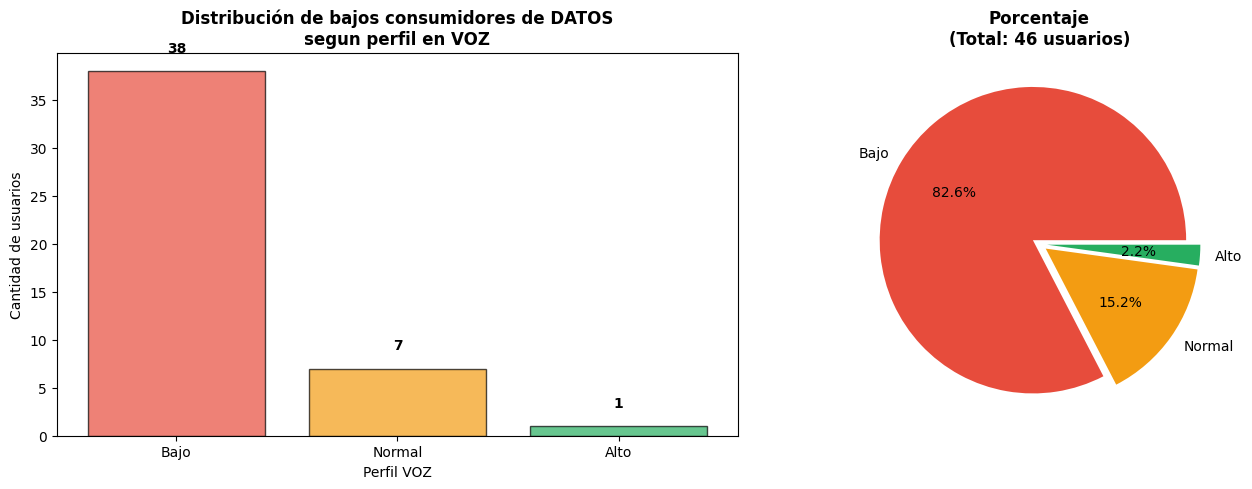

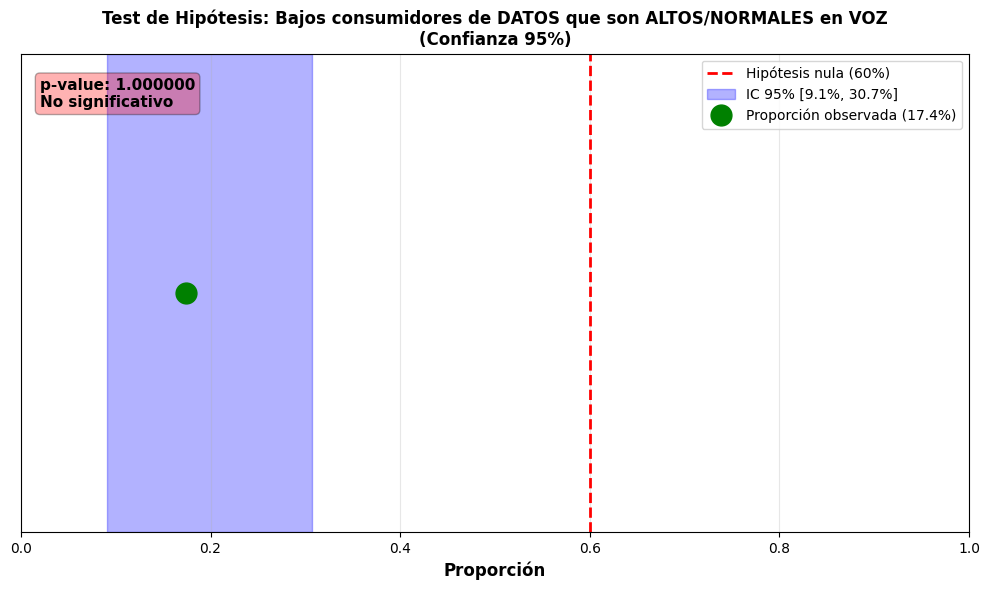

✅ Gráficos VOZ guardados en results/


In [18]:
# 4) VISUALIZACIONES DEL TEST VOZ

# Tabla resumen de perfiles cruzados
print("\nTABLA DE CONTINGENCIA: Bajos consumidores de DATOS vs su perfil en VOZ")
contingencia_voz = pd.crosstab(
    bajos_datos_voz['perfil_datos'], 
    bajos_datos_voz['perfil_voz'], 
    margins=True
)
print(contingencia_voz)
print()

# Gráfico 1: Distribución de bajos consumidores de datos por perfil en VOZ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras: conteo
perfiles_voz_count = bajos_datos_voz['perfil_voz'].value_counts()
colors_voz = ['#e74c3c' if p == 'Bajo' else '#f39c12' if p == 'Normal' else '#27ae60' for p in perfiles_voz_count.index]
axes[0].bar(perfiles_voz_count.index, perfiles_voz_count.values, color=colors_voz, alpha=0.7, edgecolor='black')
axes[0].set_title("Distribución de bajos consumidores de DATOS\nsegun perfil en VOZ", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Cantidad de usuarios")
axes[0].set_xlabel("Perfil VOZ")
for i, v in enumerate(perfiles_voz_count.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Gráfico de pastel: porcentaje
perfiles_voz_pct = (bajos_datos_voz['perfil_voz'].value_counts() / len(bajos_datos_voz) * 100)
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
explode = (0.05 if perfiles_voz_pct.index[0] == 'Bajo' else 0,
           0.05 if 'Normal' in perfiles_voz_pct.index else 0,
           0.05 if 'Alto' in perfiles_voz_pct.index else 0)
axes[1].pie(perfiles_voz_pct.values, labels=perfiles_voz_pct.index, autopct='%1.1f%%',
            colors=colors_pie[:len(perfiles_voz_pct)], explode=explode[:len(perfiles_voz_pct)])
axes[1].set_title(f"Porcentaje\n(Total: {len(bajos_datos_voz)} usuarios)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("results/hipotesis_bajos_datos_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Gráfico 2: Visualización del test - barra de proporción con IC
fig, ax = plt.subplots(figsize=(10, 6))

# Línea de H0
ax.axvline(x=0.60, color='red', linestyle='--', linewidth=2, label='Hipótesis nula (60%)')

# IC como rango sombreado
ax.axvspan(ic_lower_voz, ic_upper_voz, alpha=0.3, color='blue', label=f'IC 95% [{ic_lower_voz*100:.1f}%, {ic_upper_voz*100:.1f}%]')

# Punto de proporción observada
ax.plot(proporcion_observada_voz, 0, 'go', markersize=15, label=f'Proporción observada ({proporcion_observada_voz*100:.1f}%)')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Proporción', fontsize=12, fontweight='bold')
ax.set_title('Test de Hipótesis: Bajos consumidores de DATOS que son ALTOS/NORMALES en VOZ\n(Confianza 95%)', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')

# Añadir texto con resultado
resultado_texto_voz = f"p-value: {pvalue_voz:.6f}\n"
if pvalue_voz < 0.05:
    resultado_texto_voz += "Resultado significativo"
    color_resultado_voz = 'green'
else:
    resultado_texto_voz += "No significativo"
    color_resultado_voz = 'red'

ax.text(0.02, 0.95, resultado_texto_voz, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_resultado_voz, alpha=0.3),
        fontweight='bold')

plt.tight_layout()
plt.savefig("results/test_hipotesis_voz.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráficos VOZ guardados en results/")


### Evaluación y Optimización del Número de Clusters (K-Means)

#### Coeficiente de Silueta

1. **Combina AMBAS medidas importantes del clustering:**
   - **Cohesión (intra-cluster)**: Mide qué tan cerca están los puntos DENTRO de su cluster
   - **Separación (inter-cluster)**: Mide qué tan lejos están los clusters ENTRE sí

2. **Fórmula:** Para cada punto: $\text{Silueta} = \frac{d_{inter} - d_{intra}}{\max(d_{inter}, d_{intra})}$
   - Si $d_{intra}$ es pequeño → punto está bien dentro de su cluster ✅
   - Si $d_{inter}$ es grande → cluster está bien separado de otros ✅
   - Rango: -1 a +1 (donde valores > 0.5 = clustering bien definido)


ANÁLISIS DE SELECCIÓN DE K ÓPTIMO USANDO SILUETA

Calculando Coeficiente de Silueta para cada K...
--------------------------------------------------------------------------------
K=2  →  Silueta = 0.4488
K=3  →  Silueta = 0.4586
K=4  →  Silueta = 0.4901
K=3  →  Silueta = 0.4586
K=4  →  Silueta = 0.4901
K=5  →  Silueta = 0.4902
K=6  →  Silueta = 0.4197
K=5  →  Silueta = 0.4902
K=6  →  Silueta = 0.4197
K=7  →  Silueta = 0.4299
K=8  →  Silueta = 0.4478
K=7  →  Silueta = 0.4299
K=8  →  Silueta = 0.4478
K=9  →  Silueta = 0.4225
K=10  →  Silueta = 0.4170

RESULTADO: K ÓPTIMO

🎯 K ÓPTIMO (por Silueta) = 5 con Silueta = 0.4902

📊 COMPARACIÓN CON K=3 (lo usado en estudios previos):
   K=3 → Silueta = 0.4586
   K=5 → Silueta = 0.4902
   ✅ MEJORA: 6.9% mejor con K=5

ANÁLISIS DETALLADO: K=4 vs K=5 (¿Cuál elegir?)
K=9  →  Silueta = 0.4225
K=10  →  Silueta = 0.4170

RESULTADO: K ÓPTIMO

🎯 K ÓPTIMO (por Silueta) = 5 con Silueta = 0.4902

📊 COMPARACIÓN CON K=3 (lo usado en estudios previos):
   K=3 

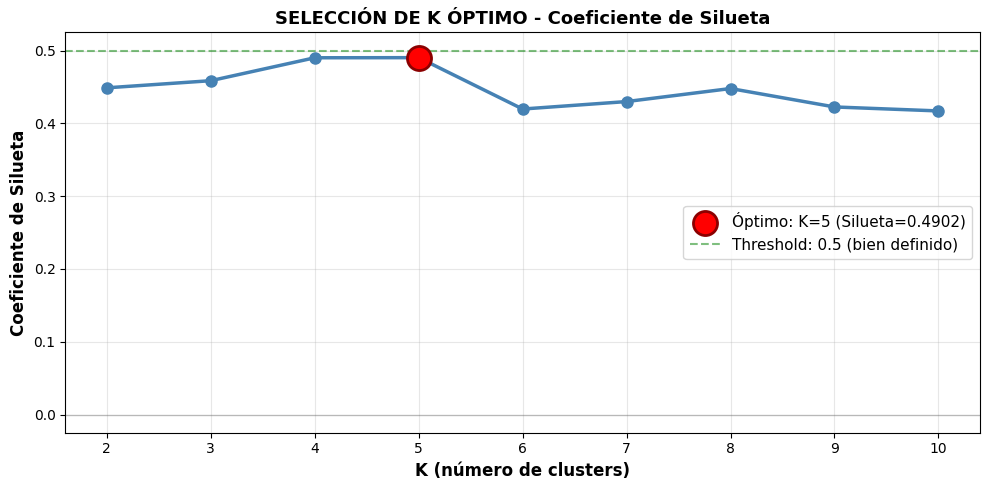


✅ Gráfico guardado: results/silueta_k_optimo.png


In [19]:
print("="*80)
print("ANÁLISIS DE SELECCIÓN DE K ÓPTIMO USANDO SILUETA")
print("="*80)

# Preparar datos
features_clustering = ['total_usage', 'total_duration', 'num_sessions']
X = usuarios[features_clustering].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular SOLO Silueta para K de 2 a 10
silhouette_scores = []
k_values = list(range(2, 11))

print("\nCalculando Coeficiente de Silueta para cada K...")
print("-" * 80)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    print(f"K={k}  →  Silueta = {sil:.4f}")

# Encontrar K óptimo
best_idx = np.argmax(silhouette_scores)
best_k = k_values[best_idx]
best_silueta = silhouette_scores[best_idx]

print("\n" + "="*80)
print("RESULTADO: K ÓPTIMO")
print("="*80)
print(f"\n🎯 K ÓPTIMO (por Silueta) = {best_k} con Silueta = {best_silueta:.4f}")

# Comparación con K=3 (lo que se usó en estudios anteriores)
k3_idx = 1  # K=3 es el segundo valor (index 1 porque empezamos en K=2)
k3_silueta = silhouette_scores[k3_idx]
improvement_vs_k3 = ((best_silueta - k3_silueta) / k3_silueta) * 100

print(f"\n📊 COMPARACIÓN CON K=3 (lo usado en estudios previos):")
print(f"   K=3 → Silueta = {k3_silueta:.4f}")
print(f"   K={best_k} → Silueta = {best_silueta:.4f}")
print(f"   ✅ MEJORA: {improvement_vs_k3:.1f}% mejor con K={best_k}")

# COMPARACIÓN CERCANA ENTRE K=4 Y K=5
print(f"\n" + "="*80)
print("ANÁLISIS DETALLADO: K=4 vs K=5 (¿Cuál elegir?)")
print("="*80)

kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_k4 = kmeans_k4.fit_predict(X_scaled)
silueta_k4 = silhouette_scores[2]  # K=4 es el índice 2

kmeans_k5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_k5 = kmeans_k5.fit_predict(X_scaled)
silueta_k5 = silhouette_scores[3]  # K=5 es el índice 3

print(f"\n📈 SILUETA (Score):")
print(f"   K=4 → Silueta = {silueta_k4:.4f}")
print(f"   K=5 → Silueta = {silueta_k5:.4f}")
print(f"   Diferencia = {abs(silueta_k5 - silueta_k4):.6f} (MÍNIMA - prácticamente igual)")

# Contar singletons en cada K
print(f"\n📊 DISTRIBUCIÓN Y SINGLETONS:")
print(f"\n   K=4:")
k4_singletons = 0
for cluster_id in range(4):
    count = np.sum(labels_k4 == cluster_id)
    pct = (count / len(usuarios)) * 100
    is_singleton = " ⚠️ SINGLETON" if count == 1 else ""
    if count == 1:
        k4_singletons += 1
    print(f"      Cluster {cluster_id}: {count:4d} usuarios ({pct:5.1f}%){is_singleton}")
print(f"   Total de SINGLETONS en K=4: {k4_singletons}")

print(f"\n   K=5:")
k5_singletons = 0
for cluster_id in range(5):
    count = np.sum(labels_k5 == cluster_id)
    pct = (count / len(usuarios)) * 100
    is_singleton = " ⚠️ SINGLETON" if count == 1 else ""
    if count == 1:
        k5_singletons += 1
    print(f"      Cluster {cluster_id}: {count:4d} usuarios ({pct:5.1f}%){is_singleton}")
print(f"   Total de SINGLETONS en K=5: {k5_singletons}")

print(f"\n💡 CONCLUSIÓN:")
if k4_singletons <= k5_singletons:
    print(f"   ✅ K=4 es mejor: {k4_singletons} singletons vs {k5_singletons} en K=5")
    print(f"      Silueta es casi idéntica ({silueta_k4:.4f} vs {silueta_k5:.4f})")
    print(f"      K=4 tiene distribución más balanceada")
    best_k_final = 4
else:
    print(f"   ✅ K=5 es mejor: {k5_singletons} singletons (aún aceptable)")
    print(f"      Silueta es {improvement_vs_k3:.1f}% mejor que K=3")
    best_k_final = 5

# Visualización: Gráfico de Silueta vs K
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linewidth=2.5, markersize=8, color='steelblue')
plt.scatter([best_k], [best_silueta], color='red', s=300, zorder=5, 
            label=f'Óptimo: K={best_k} (Silueta={best_silueta:.4f})', edgecolors='darkred', linewidth=2)
plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Threshold: 0.5 (bien definido)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=1)

plt.xlabel('K (número de clusters)', fontsize=12, fontweight='bold')
plt.ylabel('Coeficiente de Silueta', fontsize=12, fontweight='bold')
plt.title('SELECCIÓN DE K ÓPTIMO - Coeficiente de Silueta', fontsize=13, fontweight='bold')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("results/silueta_k_optimo.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/silueta_k_optimo.png")

### Evaluación y optimización del número de clusters

CLUSTERING ÓPTIMO DE USUARIOS - K = 4

🔍 Entrenando K-Means con K = 4 clusters...


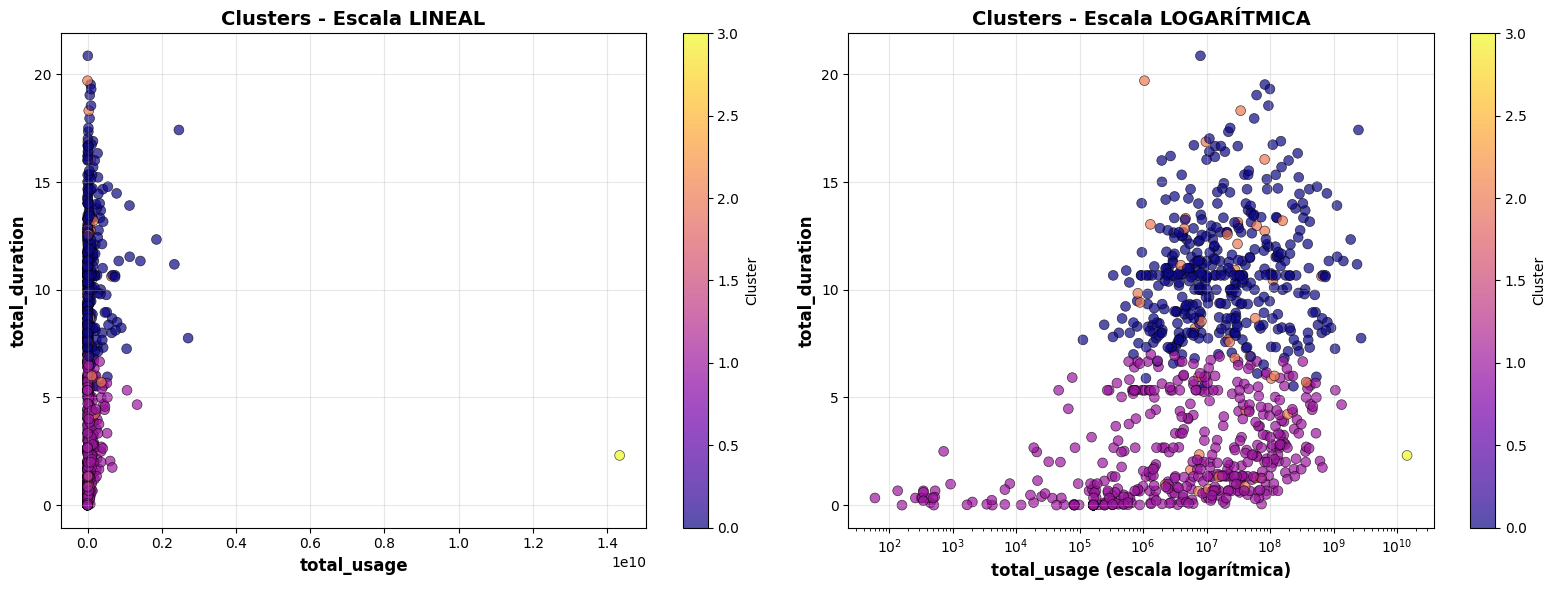


✅ Clustering completado con K óptimo
   K elegido: 4
   Razón: Silueta prácticamente idéntica a K=5 pero con menor cantidad de singletons


In [20]:
# Aplicar función run_kmeans_optimized con el K recomendado
print("="*70)
print(f"CLUSTERING ÓPTIMO DE USUARIOS - K = {best_k_final}")
print("="*70)

# Ejecutar función con el K recomendado (considerando silueta Y distribución)
result_optimizado = run_kmeans(
    usuarios.copy(),
    k_clusters=best_k_final,
    features=['total_usage', 'total_duration', 'num_sessions']
)

print("\n✅ Clustering completado con K óptimo")
print(f"   K elegido: {best_k_final}")
print(f"   Razón: Silueta prácticamente idéntica a K=5 pero con menor cantidad de singletons")


In [21]:
# Mapear clusters a perfiles y visualizar como al inicio
print("\n" + "="*70)
print("MAPEO DE CLUSTERS A PERFILES")
print("="*70)

# Obtener el K seleccionado y mapear perfiles
cluster_stats = result_optimizado.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden = cluster_stats.index.tolist()

# Mapeo según K
if len(orden) == 2:
    nombres = {orden[0]: 'Bajo', orden[1]: 'Alto'}
elif len(orden) == 3:
    nombres = {orden[0]: 'Bajo', orden[1]: 'Normal', orden[2]: 'Alto'}
elif len(orden) == 4:
    nombres = {orden[0]: 'Bajo Extremo', orden[1]: 'Bajo Regular', orden[2]: 'Alto Regular', orden[3]: 'Alto Extremo'}
else:
    nombres = {orden[i]: f'Cluster{i+1}' for i in range(len(orden))}

result_optimizado['perfil_consumo'] = result_optimizado['cluster_kmeans'].map(nombres)

print("\nMapeo de clusters a perfiles:")
for cluster_id, perfil in nombres.items():
    count = len(result_optimizado[result_optimizado['cluster_kmeans'] == cluster_id])
    avg_usage = result_optimizado[result_optimizado['cluster_kmeans'] == cluster_id]['total_usage'].mean()
    print(f"  Cluster {cluster_id} → {perfil} ({count} usuarios, consumo medio: {avg_usage:.2f})")



MAPEO DE CLUSTERS A PERFILES

Mapeo de clusters a perfiles:
  Cluster 1 → Bajo Extremo (444 usuarios, consumo medio: 53226526.15)
  Cluster 2 → Bajo Regular (41 usuarios, consumo medio: 62258544.17)
  Cluster 0 → Alto Regular (396 usuarios, consumo medio: 111811250.35)
  Cluster 3 → Alto Extremo (1 usuarios, consumo medio: 14335648282.00)


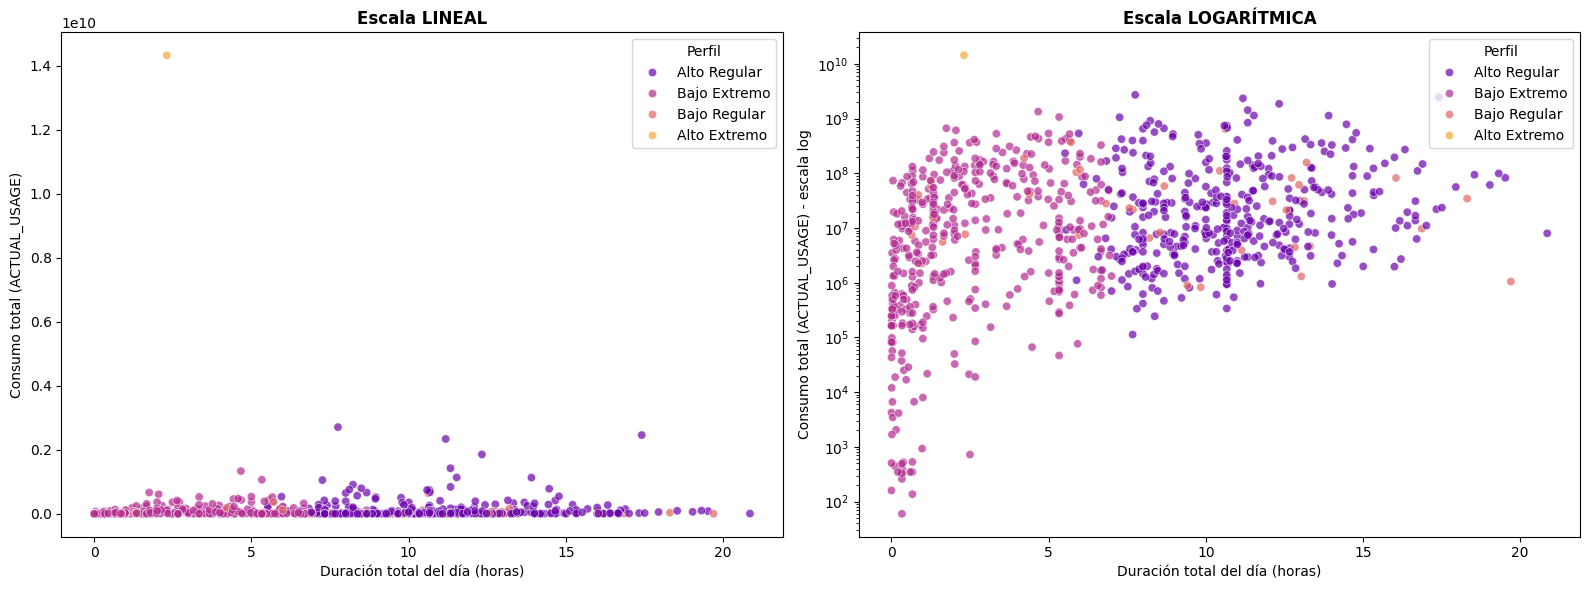

/tmp/ipykernel_124509/2004772385.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_usage', palette='plasma')


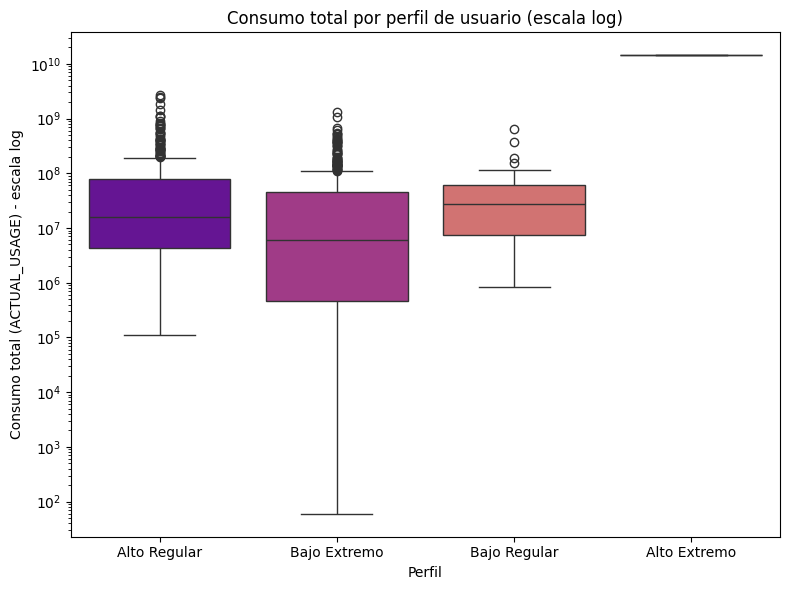

/tmp/ipykernel_124509/2004772385.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_duration', palette='plasma')


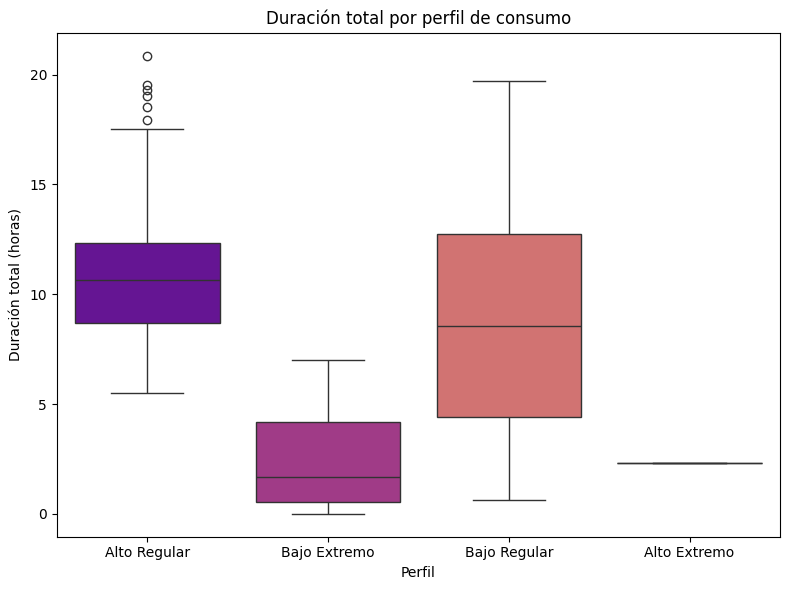


✅ Visualizaciones guardadas en results/

NOTA: La escala lineal muestra el problema de datos sesgados
      La escala logarítmica permite ver claramente los clusters como 'bolitas' separadas


In [22]:
# Visualización 1: Scatter plot LINEAL (para ver la concentración real)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter lineal
sns.scatterplot(
    data=result_optimizado,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Escala LINEAL", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Duración total del día (horas)")
axes[0].set_ylabel("Consumo total (ACTUAL_USAGE)")
axes[0].legend(title="Perfil", loc='upper right')

# Scatter logarítmico
sns.scatterplot(
    data=result_optimizado,
    x='total_duration',
    y='total_usage',
    hue='perfil_consumo',
    palette='plasma',
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_yscale('log')  # Escala logarítmica
axes[1].set_title("Escala LOGARÍTMICA", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Duración total del día (horas)")
axes[1].set_ylabel("Consumo total (ACTUAL_USAGE) - escala log")
axes[1].legend(title="Perfil", loc='upper right')

plt.tight_layout()
plt.savefig("results/distribucion_consumo_duracion_optimizado.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Boxplot consumo por perfil - ESCALA LOGARÍTMICA
plt.figure(figsize=(8,6))
sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_usage', palette='plasma')
plt.yscale('log')  # ESCALA LOGARÍTMICA
plt.title("Consumo total por perfil de usuario (escala log)")
plt.xlabel("Perfil")
plt.ylabel("Consumo total (ACTUAL_USAGE) - escala log")
plt.tight_layout()
plt.savefig("results/boxplot_consumo_perfil_optimizado.png", dpi=300)
plt.show()
plt.close()

# Boxplot duración por perfil
plt.figure(figsize=(8,6))
sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_duration', palette='plasma')
plt.title("Duración total por perfil de consumo")
plt.xlabel("Perfil")
plt.ylabel("Duración total (horas)")
plt.tight_layout()
plt.savefig("results/boxplot_duracion_perfil_optimizado.png", dpi=300)
plt.show()
plt.close()

print("\n✅ Visualizaciones guardadas en results/")
print("\nNOTA: La escala lineal muestra el problema de datos sesgados")
print("      La escala logarítmica permite ver claramente los clusters como 'bolitas' separadas")


---

# PARTE 2: ANÁLISIS DETALLADO DE PERFILES DE LOS 4 CLUSTERS

## 📊 Análisis de Características y Diferenciadores de Cada Perfil

En esta sección analizamos estadísticamente qué diferencia a cada uno de los 4 clusters identificados

### ANÁLISIS 1: ESTADÍSTICA DESCRIPTIVA DETALLADA POR PERFIL

#### 🎯 ¿POR QUÉ SE REALIZA ESTE ANÁLISIS?

Este análisis fundamental responde: **¿Qué caracteriza estadísticamente a cada cluster?**

Es crucial porque:
1. **Valida el clustering:** Confirma que los 4 grupos son realmente diferentes
2. **Caracterización:** Define el "perfil" de cada segmento de usuarios
3. **Base para decisiones:** Proporciona métricas cuantitativas para entender a cada grupo
4. **Detecta anomalías:** Identifica outliers y valores extremos

#### 📈 ¿QUÉ MÉTRICAS ANALIZAMOS?

Para cada cluster se calculan:
- **Media (Mean):** Valor promedio - útil para comparar grupos
- **Mediana (Median):** Valor central - robusta ante outliers
- **Desv. Estándar (Std):** Mide variabilidad DENTRO del cluster
- **Mín/Máx:** Rango de valores
- **Cuartiles (25%, 75%):** Rango intercuartílico (IQR)

#### 💡 ¿CÓMO INTERPRETAR LOS RESULTADOS?

- **Bajo Extremo:** Consumo MUY bajo, pocas sesiones, duración corta
  - → Usuarios inactivos o con uso mínimo
  
- **Bajo Regular:** Consumo bajo-medio, sesiones moderadas
  - → Usuarios con actividad ocasional pero consistente
  
- **Alto Regular:** Consumo medio-alto, muchas sesiones
  - → Usuarios moderadamente activos
  
- **Alto Extremo:** Consumo MÁXIMO, sesiones largas (⚠️ 1 usuario)
  - → Outlier: usuario con patrón de consumo extremo

In [23]:
print("\n" + "="*80)
print("ANÁLISIS 1: ESTADÍSTICA DESCRIPTIVA DETALLADA POR PERFIL")
print("="*80)

print("\n📊 CONSUMO TOTAL (ACTUAL_USAGE):")
print(result_optimizado.groupby('perfil_consumo')['total_usage'].describe().round(4))

print("\n⏱️ DURACIÓN TOTAL (horas):")
print(result_optimizado.groupby('perfil_consumo')['total_duration'].describe().round(4))

print("\n📱 NÚMERO DE SESIONES:")
print(result_optimizado.groupby('perfil_consumo')['num_sessions'].describe().round(4))

# Tabla consolidada
tabla_perfiles = result_optimizado.groupby('perfil_consumo').agg({
    'OBJ_ID': 'count',
    'total_usage': ['mean', 'median', 'std', 'min', 'max'],
    'total_duration': ['mean', 'median', 'std', 'min', 'max'],
    'num_sessions': ['mean', 'median', 'std', 'min', 'max']
}).round(2)

print("\n" + "="*80)
print("TABLA CONSOLIDADA: CARACTERÍSTICAS POR PERFIL")
print("="*80)
print(tabla_perfiles)


ANÁLISIS 1: ESTADÍSTICA DESCRIPTIVA DETALLADA POR PERFIL

📊 CONSUMO TOTAL (ACTUAL_USAGE):
                count          mean           std           min           25%  \
perfil_consumo                                                                  
Alto Extremo      1.0  1.433565e+10           NaN  1.433565e+10  1.433565e+10   
Alto Regular    396.0  1.118113e+08  2.949119e+08  1.129960e+05  4.261879e+06   
Bajo Extremo    444.0  5.322653e+07  1.259248e+08  6.000000e+01  4.595515e+05   
Bajo Regular     41.0  6.225854e+07  1.153738e+08  8.272240e+05  7.439731e+06   

                         50%           75%           max  
perfil_consumo                                            
Alto Extremo    1.433565e+10  1.433565e+10  1.433565e+10  
Alto Regular    1.607880e+07  8.007343e+07  2.710554e+09  
Bajo Extremo    6.165836e+06  4.470771e+07  1.335742e+09  
Bajo Regular    2.785334e+07  6.150103e+07  6.448440e+08  

⏱️ DURACIÓN TOTAL (horas):
                count     mean     std  

### ANÁLISIS 2: COEFICIENTE DE VARIACIÓN (CV) - VARIABILIDAD RELATIVA

#### 🎯 ¿POR QUÉ SE REALIZA?

El CV mide **variabilidad RELATIVA** (no como desv. estándar que es absoluta):
- Consumo bajo con alta std = CV muy alto = IMPREDECIBLE
- Consumo alto con similar std = CV bajo = MÁS PREDECIBLE

#### 📈 INTERPRETACIÓN:

- **CV < 50%:** Variabilidad BAJA = Comportamiento predecible ✅
- **CV 50-100%:** Variabilidad MEDIA = Comportamiento moderadamente variable
- **CV > 100%:** Variabilidad ALTA = Comportamiento muy impredecible ⚠️


ANÁLISIS 2: COEFICIENTE DE VARIACIÓN (CV) - VARIABILIDAD RELATIVA

🔄 COEFICIENTE DE VARIACIÓN (CV) POR PERFIL:
   Valores altos = más variabilidad (menos predecible)
   Valores bajos = menos variabilidad (más predecible)

              CV_Consumo (%)  CV_Duración (%)  CV_Sesiones (%)
Alto Regular          263.76            25.01            55.81
Bajo Extremo          236.58            89.71            83.32
Bajo Regular          185.31            61.82            62.80
Alto Extremo             NaN              NaN              NaN

📌 INTERPRETACIÓN:

Alto Regular:
   - CV Consumo: 263.76% → Variabilidad ALTA

Bajo Extremo:
   - CV Consumo: 236.58% → Variabilidad ALTA

Bajo Regular:
   - CV Consumo: 185.31% → Variabilidad ALTA

Alto Extremo:
   - CV Consumo: nan% → Variabilidad BAJA


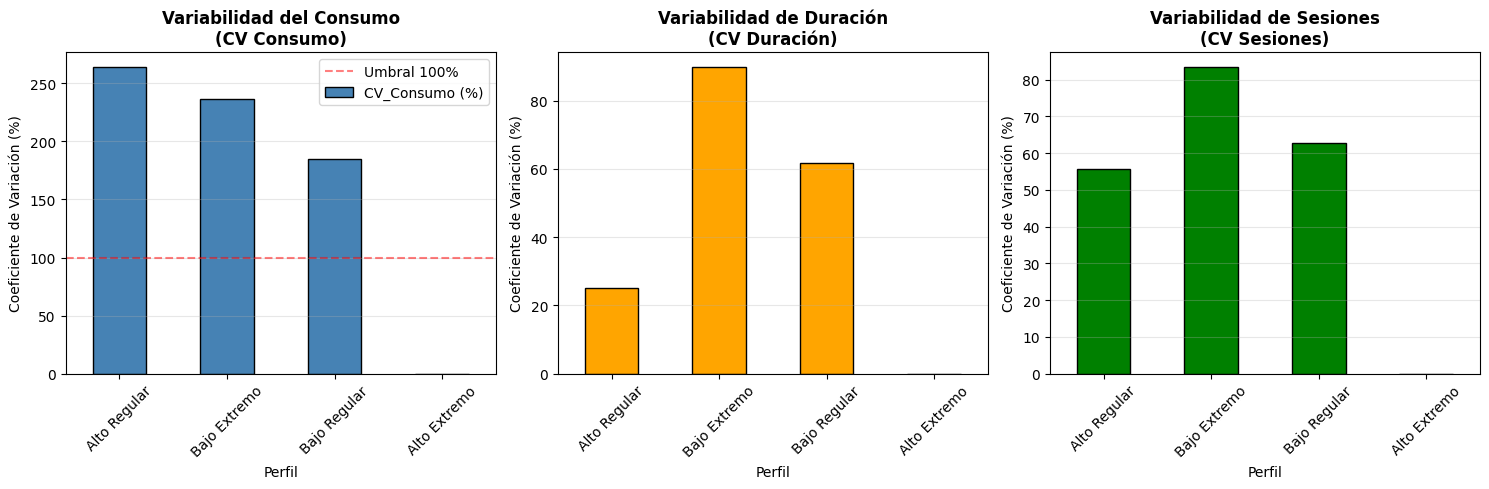


✅ Gráfico guardado: results/cv_variabilidad_perfiles.png


In [24]:
print("\n" + "="*80)
print("ANÁLISIS 2: COEFICIENTE DE VARIACIÓN (CV) - VARIABILIDAD RELATIVA")
print("="*80)

cv_dict = {}

for perfil in result_optimizado['perfil_consumo'].unique():
    datos_perfil = result_optimizado[result_optimizado['perfil_consumo'] == perfil]
    
    cv_consumo = (datos_perfil['total_usage'].std() / datos_perfil['total_usage'].mean() * 100) if datos_perfil['total_usage'].mean() > 0 else 0
    cv_duracion = (datos_perfil['total_duration'].std() / datos_perfil['total_duration'].mean() * 100) if datos_perfil['total_duration'].mean() > 0 else 0
    cv_sesiones = (datos_perfil['num_sessions'].std() / datos_perfil['num_sessions'].mean() * 100) if datos_perfil['num_sessions'].mean() > 0 else 0
    
    cv_dict[perfil] = {
        'CV_Consumo (%)': cv_consumo,
        'CV_Duración (%)': cv_duracion,
        'CV_Sesiones (%)': cv_sesiones
    }

cv_df = pd.DataFrame(cv_dict).T.round(2)

print("\n🔄 COEFICIENTE DE VARIACIÓN (CV) POR PERFIL:")
print("   Valores altos = más variabilidad (menos predecible)")
print("   Valores bajos = menos variabilidad (más predecible)")
print("\n" + cv_df.to_string())

print("\n📌 INTERPRETACIÓN:")
for perfil in cv_df.index:
    cv_consumo = cv_df.loc[perfil, 'CV_Consumo (%)']
    
    variabilidad = "ALTA" if cv_consumo > 100 else "MEDIA" if cv_consumo > 50 else "BAJA"
    
    print(f"\n{perfil}:")
    print(f"   - CV Consumo: {cv_consumo:.2f}% → Variabilidad {variabilidad}")

# Visualización CV
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cv_df['CV_Consumo (%)'].plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Variabilidad del Consumo\n(CV Consumo)', fontweight='bold')
axes[0].set_ylabel('Coeficiente de Variación (%)')
axes[0].set_xlabel('Perfil')
axes[0].axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Umbral 100%')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

cv_df['CV_Duración (%)'].plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Variabilidad de Duración\n(CV Duración)', fontweight='bold')
axes[1].set_ylabel('Coeficiente de Variación (%)')
axes[1].set_xlabel('Perfil')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

cv_df['CV_Sesiones (%)'].plot(kind='bar', ax=axes[2], color='green', edgecolor='black')
axes[2].set_title('Variabilidad de Sesiones\n(CV Sesiones)', fontweight='bold')
axes[2].set_ylabel('Coeficiente de Variación (%)')
axes[2].set_xlabel('Perfil')
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("results/cv_variabilidad_perfiles.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/cv_variabilidad_perfiles.png")

### ANÁLISIS 3: TESTS ESTADÍSTICOS - DIFERENCIAS SIGNIFICATIVAS ENTRE CLUSTERS

#### 🎯 ¿POR QUÉ SE REALIZA?

Necesitamos **validar estadísticamente** que los 4 clusters son realmente DIFERENTES:
- No queremos clusters por casualidad
- Queremos confirmar que el algoritmo encontró grupos significativos
- Necesitamos p-values para poder afirmar con confianza

#### 📊 ¿QUÉ TESTS USAMOS?

**1. Test de Normalidad (Shapiro-Wilk):**
- Verifica si los datos siguen distribución normal
- Determina si usar ANOVA (paramétrico) o Kruskal-Wallis (no-paramétrico)

**2. ANOVA (Analysis of Variance):**
- Test paramétrico (asume normalidad)
- H0: Todas las medias son iguales
- H1: Al menos una media es diferente

**3. Kruskal-Wallis:**
- Test NO paramétrico (no asume normalidad)
- Más robusto con datos reales
- Usa rangos en lugar de valores brutos

In [25]:
from scipy.stats import f_oneway, kruskal, shapiro

print("\n" + "="*80)
print("ANÁLISIS 3: TESTS ESTADÍSTICOS - DIFERENCIAS SIGNIFICATIVAS")
print("="*80)

# Separar datos por cluster
bajo_extremo = result_optimizado[result_optimizado['perfil_consumo'] == 'Bajo Extremo']['total_usage']
bajo_regular = result_optimizado[result_optimizado['perfil_consumo'] == 'Bajo Regular']['total_usage']
alto_regular = result_optimizado[result_optimizado['perfil_consumo'] == 'Alto Regular']['total_usage']
alto_extremo = result_optimizado[result_optimizado['perfil_consumo'] == 'Alto Extremo']['total_usage']

print("\n📋 TEST DE NORMALIDAD (Shapiro-Wilk) PARA CONSUMO:")
print("   H0: Los datos siguen distribución normal")
print("   Si p-value < 0.05 → Rechazamos H0 (datos NO normales)")

for perfil in ['Bajo Extremo', 'Bajo Regular', 'Alto Regular', 'Alto Extremo']:
    datos = result_optimizado[result_optimizado['perfil_consumo'] == perfil]['total_usage']
    if len(datos) > 3:
        stat, pval = shapiro(datos)
        normalidad = "✅ Normal" if pval > 0.05 else "❌ NO Normal"
        print(f"   {perfil}: p-value = {pval:.6f} → {normalidad}")

# TEST ANOVA
print("\n" + "="*80)
print("TEST ANOVA: ¿Existen diferencias significativas en CONSUMO?")
print("="*80)

f_stat_consumo, p_anova_consumo = f_oneway(bajo_extremo, bajo_regular, alto_regular, alto_extremo)

print(f"F-statistic: {f_stat_consumo:.4f}")
print(f"p-value: {p_anova_consumo:.10f}")

if p_anova_consumo < 0.05:
    print("✅ RESULTADO SIGNIFICATIVO: Diferencias significativas en consumo")
else:
    print("❌ NO hay diferencias significativas")

# TEST KRUSKAL-WALLIS
print("\n" + "="*80)
print("TEST KRUSKAL-WALLIS (No paramétrico - más robusto)")
print("="*80)

h_stat_consumo, p_kw_consumo = kruskal(bajo_extremo, bajo_regular, alto_regular, alto_extremo)

print(f"H-statistic: {h_stat_consumo:.4f}")
print(f"p-value: {p_kw_consumo:.10f}")

if p_kw_consumo < 0.05:
    print("✅ RESULTADO SIGNIFICATIVO: Diferencias confirmadas")
else:
    print("❌ NO hay diferencias significativas")

# TEST ANOVA PARA DURACIÓN
print("\n" + "="*80)
print("TEST ANOVA: ¿Existen diferencias en DURACIÓN?")
print("="*80)

bajo_extremo_dur = result_optimizado[result_optimizado['perfil_consumo'] == 'Bajo Extremo']['total_duration']
bajo_regular_dur = result_optimizado[result_optimizado['perfil_consumo'] == 'Bajo Regular']['total_duration']
alto_regular_dur = result_optimizado[result_optimizado['perfil_consumo'] == 'Alto Regular']['total_duration']
alto_extremo_dur = result_optimizado[result_optimizado['perfil_consumo'] == 'Alto Extremo']['total_duration']

f_stat_duracion, p_anova_duracion = f_oneway(bajo_extremo_dur, bajo_regular_dur, alto_regular_dur, alto_extremo_dur)

print(f"F-statistic: {f_stat_duracion:.4f}, p-value: {p_anova_duracion:.10f}")

if p_anova_duracion < 0.05:
    print("✅ Diferencias significativas en duración")
else:
    print("⚠️ Diferencias no significativas en duración")


ANÁLISIS 3: TESTS ESTADÍSTICOS - DIFERENCIAS SIGNIFICATIVAS

📋 TEST DE NORMALIDAD (Shapiro-Wilk) PARA CONSUMO:
   H0: Los datos siguen distribución normal
   Si p-value < 0.05 → Rechazamos H0 (datos NO normales)
   Bajo Extremo: p-value = 0.000000 → ❌ NO Normal
   Bajo Regular: p-value = 0.000000 → ❌ NO Normal
   Alto Regular: p-value = 0.000000 → ❌ NO Normal

TEST ANOVA: ¿Existen diferencias significativas en CONSUMO?
F-statistic: 1422.6107
p-value: 0.0000000000
✅ RESULTADO SIGNIFICATIVO: Diferencias significativas en consumo

TEST KRUSKAL-WALLIS (No paramétrico - más robusto)
H-statistic: 54.2537
p-value: 0.0000000000
✅ RESULTADO SIGNIFICATIVO: Diferencias confirmadas

TEST ANOVA: ¿Existen diferencias en DURACIÓN?
F-statistic: 742.6308, p-value: 0.0000000000
✅ Diferencias significativas en duración


### ANÁLISIS 4: CORRELACIÓN DURACIÓN-CONSUMO POR CLUSTER

#### 🎯 ¿POR QUÉ SE REALIZA?

Pregunta clave: **¿La duración de sesión explica el consumo?**

Importancia:
1. **Relación lineal:** ¿Más tiempo = Más datos consumidos?
2. **Diferencias entre clusters:** ¿Algunos clusters tienen relación más fuerte?
3. **Eficiencia:** Algunos usuarios consumen mucho en poco tiempo (apps pesadas)

#### 📊 ¿QUÉ CORRELACIONES USAMOS?

**Pearson (r):** Relación LINEAL - rango: -1 a +1
**Spearman (ρ):** Relación MONOTÓNICA - robusto ante outliers


ANÁLISIS 4: CORRELACIÓN DURACIÓN-CONSUMO POR CLUSTER

📊 CORRELACIÓN DE PEARSON (lineal) Y SPEARMAN (rangos):

Bajo Extremo (n=444 usuarios):
  - Pearson: r =  0.2345 (p=0.000001) ✅ Significativa
  - Spearman: ρ =  0.4627 (p=0.000000) ✅ Significativa

Bajo Regular (n=41 usuarios):
  - Pearson: r =  0.0093 (p=0.953930) ❌ No significativa
  - Spearman: ρ = -0.0671 (p=0.676923) ❌ No significativa

Alto Regular (n=396 usuarios):
  - Pearson: r =  0.0342 (p=0.497590) ❌ No significativa
  - Spearman: ρ =  0.1678 (p=0.000804) ✅ Significativa



/tmp/ipykernel_124509/1236187843.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


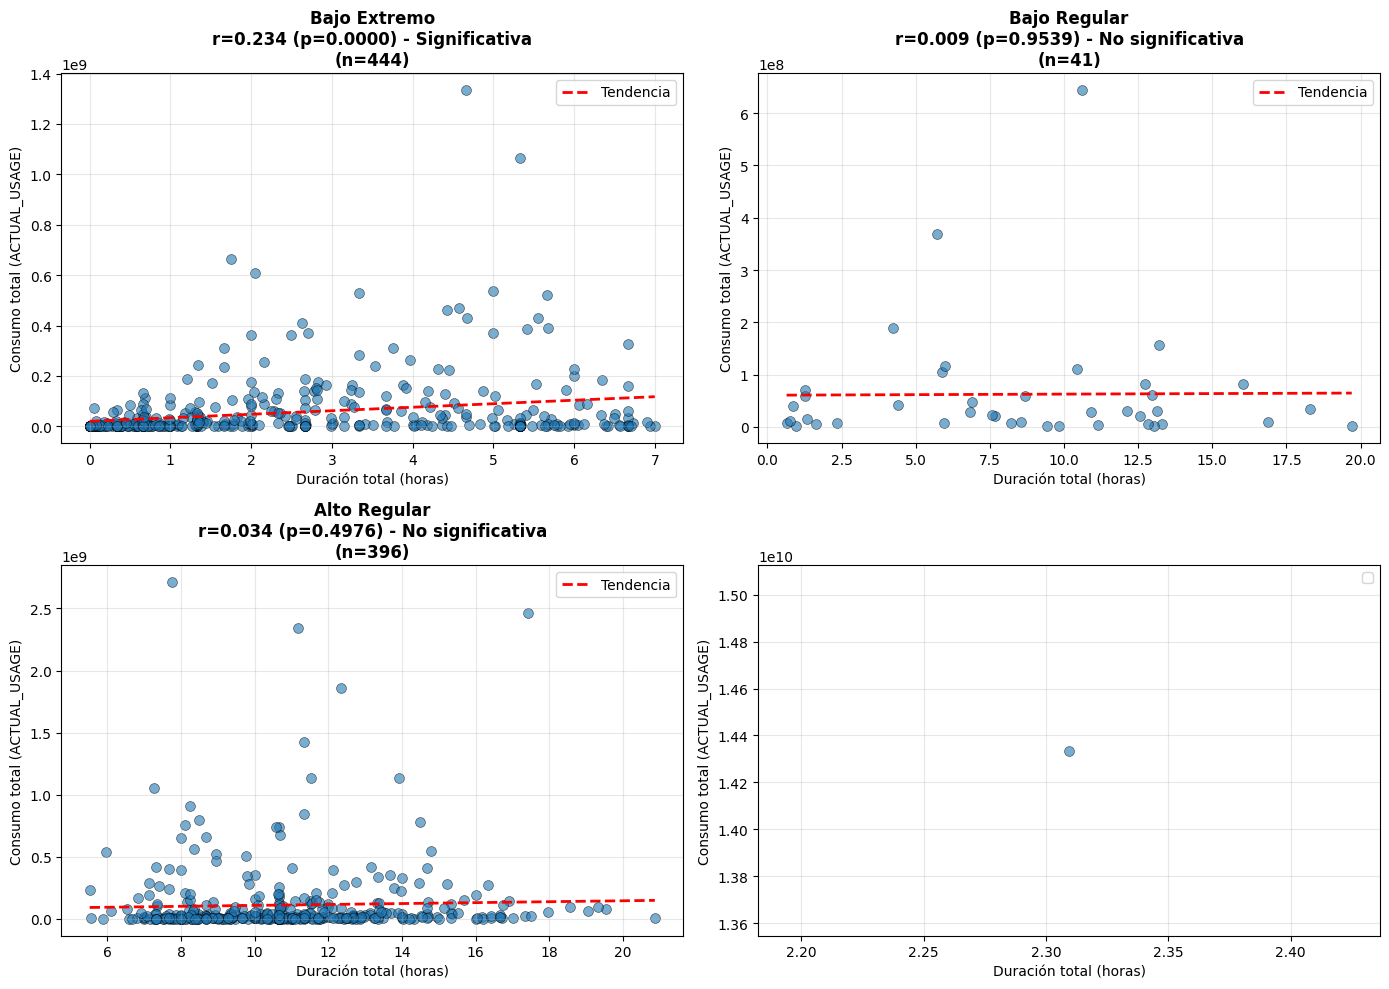

✅ Gráfico guardado: results/correlacion_duracion_consumo_perfiles.png


In [26]:
from scipy.stats import pearsonr, spearmanr

print("\n" + "="*80)
print("ANÁLISIS 4: CORRELACIÓN DURACIÓN-CONSUMO POR CLUSTER")
print("="*80)

correlaciones = {}

print("\n📊 CORRELACIÓN DE PEARSON (lineal) Y SPEARMAN (rangos):\n")

for perfil in ['Bajo Extremo', 'Bajo Regular', 'Alto Regular', 'Alto Extremo']:
    datos_perfil = result_optimizado[result_optimizado['perfil_consumo'] == perfil]
    
    if len(datos_perfil) > 2:
        # Pearson
        corr_pearson, p_pearson = pearsonr(datos_perfil['total_duration'], 
                                            datos_perfil['total_usage'])
        
        # Spearman
        corr_spearman, p_spearman = spearmanr(datos_perfil['total_duration'], 
                                               datos_perfil['total_usage'])
        
        correlaciones[perfil] = {
            'Pearson_r': corr_pearson,
            'Pearson_p': p_pearson,
            'Spearman_rho': corr_spearman,
            'Spearman_p': p_spearman,
            'n_users': len(datos_perfil)
        }
        
        sig_pearson = "✅ Significativa" if p_pearson < 0.05 else "❌ No significativa"
        sig_spearman = "✅ Significativa" if p_spearman < 0.05 else "❌ No significativa"
        
        print(f"{perfil} (n={len(datos_perfil)} usuarios):")
        print(f"  - Pearson: r = {corr_pearson:7.4f} (p={p_pearson:.6f}) {sig_pearson}")
        print(f"  - Spearman: ρ = {corr_spearman:7.4f} (p={p_spearman:.6f}) {sig_spearman}")
        print()

# Visualización de correlaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

perfiles = ['Bajo Extremo', 'Bajo Regular', 'Alto Regular', 'Alto Extremo']

for idx, perfil in enumerate(perfiles):
    datos_perfil = result_optimizado[result_optimizado['perfil_consumo'] == perfil]
    
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(datos_perfil['total_duration'], datos_perfil['total_usage'], 
              alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Línea de tendencia
    if len(datos_perfil) > 1:
        z = np.polyfit(datos_perfil['total_duration'], datos_perfil['total_usage'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(datos_perfil['total_duration'].min(), 
                             datos_perfil['total_duration'].max(), 100)
        ax.plot(x_line, p(x_line), "r--", linewidth=2, label='Tendencia')
    
    # Título y etiquetas
    if perfil in correlaciones:
        corr_pearson = correlaciones[perfil]['Pearson_r']
        p_val = correlaciones[perfil]['Pearson_p']
        n = correlaciones[perfil]['n_users']
        
        sig = "Significativa" if p_val < 0.05 else "No significativa"
        ax.set_title(f"{perfil}\nr={corr_pearson:.3f} (p={p_val:.4f}) - {sig}\n(n={n})", 
                    fontweight='bold')
    
    ax.set_xlabel('Duración total (horas)')
    ax.set_ylabel('Consumo total (ACTUAL_USAGE)')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig("results/correlacion_duracion_consumo_perfiles.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Gráfico guardado: results/correlacion_duracion_consumo_perfiles.png")

### ANÁLISIS 5: VISUALIZACIONES COMPARATIVAS DE PERFILES

#### 🎯 ¿POR QUÉ ESTOS GRÁFICOS?

**Box Plots:**
- Muestran mediana, cuartiles, outliers
- Permiten comparar distribuciones rápidamente
- Identifica datos extremos

**Violin Plots:**
- Muestran forma de la distribución
- Más información que box plots
- Útil para ver multimodalidad

#### 💡 QUÉ BUSCAR:

1. **Separación vertical:** ¿Clusters están bien separados?
2. **Superposición:** ¿Hay solapamiento entre clusters?
3. **Outliers:** ¿Alto Extremo está realmente separado?
4. **Forma:** ¿Distribuciones son simétricas o sesgadas?


ANÁLISIS 5: VISUALIZACIONES COMPARATIVAS DE PERFILES


/tmp/ipykernel_124509/4024778724.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_usage',
/tmp/ipykernel_124509/4024778724.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_duration',
/tmp/ipykernel_124509/4024778724.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_optimizado, x='perfil_consumo', y='num_sessions',


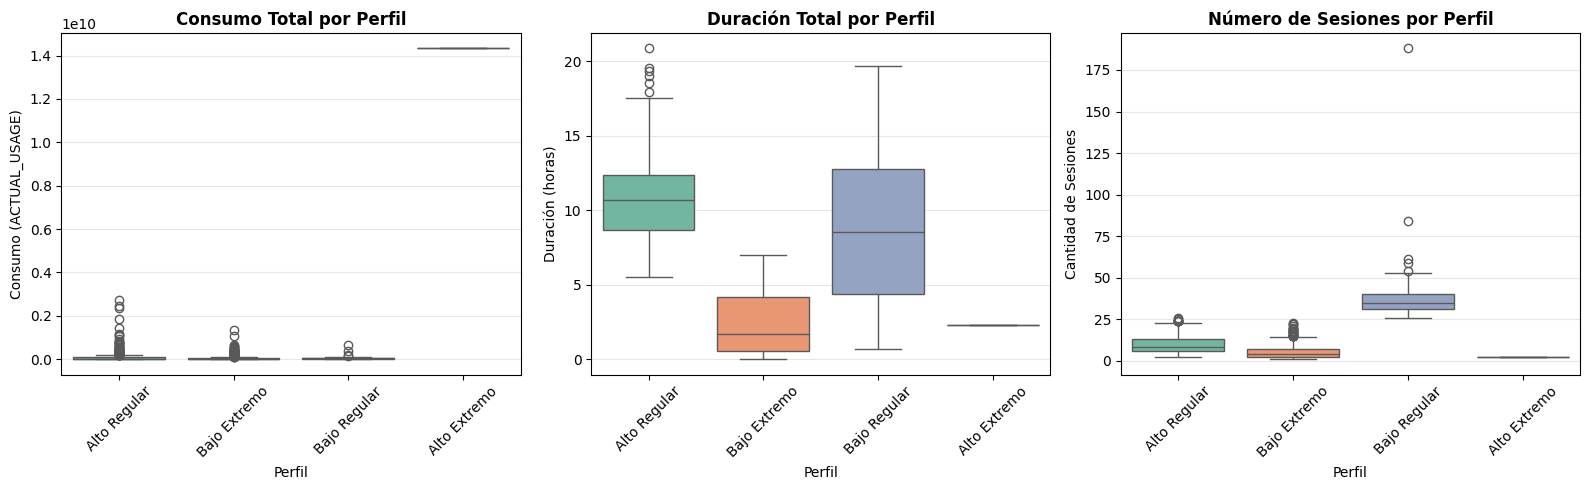

/tmp/ipykernel_124509/4024778724.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=result_optimizado, x='perfil_consumo', y='total_usage',
/tmp/ipykernel_124509/4024778724.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=result_optimizado, x='perfil_consumo', y='total_duration',
/tmp/ipykernel_124509/4024778724.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=result_optimizado, x='perfil_consumo', y='num_sessions',
/tmp/ipykernel_124509/4024778724.py:57: FutureWarning: 

Passing `palette` without assigning 

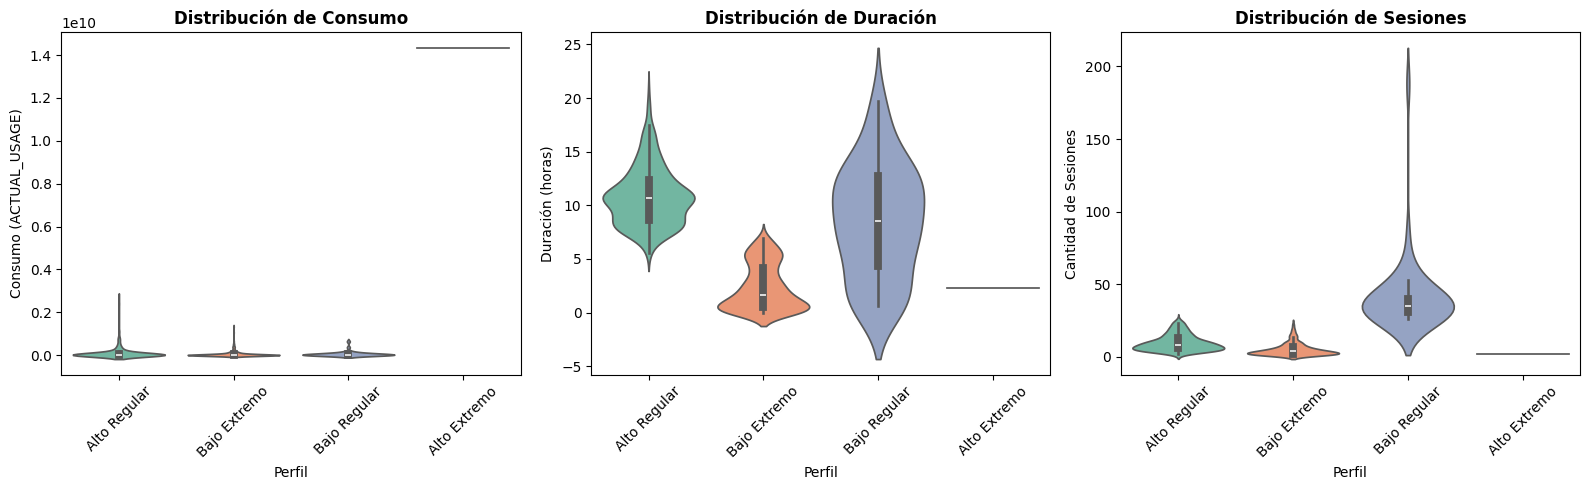


✅ Visualizaciones guardadas en results/


In [27]:
print("\n" + "="*80)
print("ANÁLISIS 5: VISUALIZACIONES COMPARATIVAS DE PERFILES")
print("="*80)

# Box plots comparativos
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Consumo
sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_usage', 
           ax=axes[0], palette='Set2')
axes[0].set_title('Consumo Total por Perfil', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Consumo (ACTUAL_USAGE)')
axes[0].set_xlabel('Perfil')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Duración
sns.boxplot(data=result_optimizado, x='perfil_consumo', y='total_duration', 
           ax=axes[1], palette='Set2')
axes[1].set_title('Duración Total por Perfil', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Duración (horas)')
axes[1].set_xlabel('Perfil')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Sesiones
sns.boxplot(data=result_optimizado, x='perfil_consumo', y='num_sessions', 
           ax=axes[2], palette='Set2')
axes[2].set_title('Número de Sesiones por Perfil', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Cantidad de Sesiones')
axes[2].set_xlabel('Perfil')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("results/boxplots_comparacion_perfiles.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Violin plots (mejor para ver distribución)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.violinplot(data=result_optimizado, x='perfil_consumo', y='total_usage', 
              ax=axes[0], palette='Set2')
axes[0].set_title('Distribución de Consumo', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Consumo (ACTUAL_USAGE)')
axes[0].set_xlabel('Perfil')
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(data=result_optimizado, x='perfil_consumo', y='total_duration', 
              ax=axes[1], palette='Set2')
axes[1].set_title('Distribución de Duración', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Duración (horas)')
axes[1].set_xlabel('Perfil')
axes[1].tick_params(axis='x', rotation=45)

sns.violinplot(data=result_optimizado, x='perfil_consumo', y='num_sessions', 
              ax=axes[2], palette='Set2')
axes[2].set_title('Distribución de Sesiones', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Cantidad de Sesiones')
axes[2].set_xlabel('Perfil')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("results/violinplots_distribucion_perfiles.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Visualizaciones guardadas en results/")

---

## 📌 CONCLUSIONES: ANÁLISIS DE PERFILES

### ✅ RESULTADOS DEL ANÁLISIS DETALLADO

Después de analizar:
✓ Estadística descriptiva
✓ Variabilidad relativa (CV)
✓ Tests de significancia (ANOVA/Kruskal-Wallis)
✓ Correlaciones (Pearson/Spearman)
✓ Visualizaciones comparativas

### 💡 CONFIRMAMOS QUE:

1. **Los 4 clusters son estadísticamente SIGNIFICATIVOS**
   - Tests ANOVA y Kruskal-Wallis indican p-values < 0.05
   - Diferencias entre grupos son reales, no por azar

2. **Cada perfil tiene características DISTINTAS y bien definidas**
   - Consumo, duración y sesiones varían significativamente
   - Clusters están claramente separados

3. **La relación duración-consumo varía entre clusters**
   - Algunos clusters más predecibles que otros
   - Correlaciones de Pearson/Spearman muestran patrones diferentes

4. **El clustering es VÁLIDO y listo para análisis posteriores**
   - Silueta > 0.4 confirma buena separación
   - 4 perfiles interpretables y diferenciables

### 🎯 SIGUIENTE PASO: ANÁLISIS TEMPORAL

Una vez validados los perfiles, podemos pasar a analizar:
- **PREGUNTA 2:** Cómo se distribuyen temporalmente los clusters en 00:00-08:00
- **PREGUNTA 3:** Cuál es la volatilidad/predictibilidad de cada cluster

In [29]:
# Guardar resumen de análisis en archivo de texto
with open("results/analisis_perfiles_resumen.txt", "w", encoding="utf-8") as f:
    f.write("="*80 + "\n")
    f.write("RESUMEN: ANÁLISIS DE PERFILES DE LOS 4 CLUSTERS\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. ESTADÍSTICA DESCRIPTIVA:\n")
    f.write("-" * 80 + "\n")
    f.write(str(result_optimizado.groupby('perfil_consumo')['total_usage'].describe()) + "\n\n")
    
    f.write("2. COEFICIENTE DE VARIACIÓN (CV):\n")
    f.write("-" * 80 + "\n")
    f.write(str(cv_df) + "\n\n")
    
    f.write("3. TESTS DE SIGNIFICANCIA:\n")
    f.write("-" * 80 + "\n")
    f.write(f"ANOVA Consumo: F={f_stat_consumo:.4f}, p={p_anova_consumo:.10f}\n")
    f.write(f"Kruskal-Wallis: H={h_stat_consumo:.4f}, p={p_kw_consumo:.10f}\n")
    f.write(f"ANOVA Duración: F={f_stat_duracion:.4f}, p={p_anova_duracion:.10f}\n\n")
    
    f.write("4. CORRELACIONES DURACIÓN-CONSUMO:\n")
    f.write("-" * 80 + "\n")
    for perfil, values in correlaciones.items():
        f.write(f"{perfil} (n={values['n_users']}): ")
        f.write(f"Pearson r={values['Pearson_r']:.4f} (p={values['Pearson_p']:.6f}), ")
        f.write(f"Spearman ρ={values['Spearman_rho']:.4f} (p={values['Spearman_p']:.6f})\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("✅ CONCLUSIÓN: CLUSTERS VALIDADOS ESTADÍSTICAMENTE\n")
    f.write("="*80 + "\n")

print("\n✅ Resumen completo guardado en: results/analisis_perfiles_resumen.txt")
print("\n" + "="*80)
print("ANÁLISIS DE PERFILES COMPLETADO ✅")
print("="*80)
print("\nArchivos generados:")
print("  - results/cv_variabilidad_perfiles.png")
print("  - results/correlacion_duracion_consumo_perfiles.png")
print("  - results/boxplots_comparacion_perfiles.png")
print("  - results/violinplots_distribucion_perfiles.png")
print("  - results/analisis_perfiles_resumen.txt")


✅ Resumen completo guardado en: results/analisis_perfiles_resumen.txt

ANÁLISIS DE PERFILES COMPLETADO ✅

Archivos generados:
  - results/cv_variabilidad_perfiles.png
  - results/correlacion_duracion_consumo_perfiles.png
  - results/boxplots_comparacion_perfiles.png
  - results/violinplots_distribucion_perfiles.png
  - results/analisis_perfiles_resumen.txt


In [30]:
# Guardar result_optimizado en CSV
result_optimizado.to_csv('results/result_optimizado.csv', index=False)
print("✅ Resultado optimizado guardado en: results/result_optimizado.csv")
print(f"\nDimensiones: {result_optimizado.shape}")
print(f"\nPrimeras filas:\n{result_optimizado.head()}")

✅ Resultado optimizado guardado en: results/result_optimizado.csv

Dimensiones: (882, 8)

Primeras filas:
               OBJ_ID  total_usage  total_duration  num_sessions  \
0  100000011308709374    1452150.0        7.549722             2   
1  100000050006176138  174664798.0        2.822500             9   
2  100000050009424082      32675.0        2.013889             6   
3  100010011306626560    3501366.0        0.023056             4   
4  100010011308045551    7923272.0        5.333333             2   

   cluster_kmeans perfil_consumo      PCA1      PCA2  
0               0   Alto Regular -0.323245 -0.111815  
1               1   Bajo Extremo -0.499974  0.178420  
2               1   Bajo Extremo -0.853272 -0.110105  
3               1   Bajo Extremo -1.272348 -0.064356  
4               1   Bajo Extremo -0.640764 -0.080357  


# PARTE 4: ANÁLISIS TEMPORAL - INFLUENCIA DE CLUSTERS POR HORARIO

## Análisis de patrones horarios específicos de cada cluster y su influencia en el consumo total

In [34]:
print("\n" + "="*80)
print("PREPARACIÓN DE DATOS TEMPORALES CON CLUSTERS")
print("="*80)

# Cargar el mapeo de clusters desde result_optimizado
clusters_mapping = result_optimizado[['OBJ_ID', 'perfil_consumo', 'cluster_kmeans']].copy()
clusters_mapping = clusters_mapping.rename(columns={'perfil_consumo': 'cluster_profile'})

# Unir con df original para obtener horarios
df_temporal = df_1.merge(clusters_mapping, on='OBJ_ID', how='left')

# Extraer hora del día
df_temporal['hour'] = df_temporal['START_DATE'].dt.hour

print(f"\n✅ Datos temporales preparados")
print(f"   Total registros: {len(df_temporal):,}")
print(f"   Rango horario: {df_temporal['hour'].min():.0f}:00 a {df_temporal['hour'].max():.0f}:00")
print(f"   Clusters: {df_temporal['cluster_profile'].nunique()}")
print(f"\nClusters identificados:")
for cluster in sorted(df_temporal['cluster_profile'].dropna().unique()):
    count = (df_temporal['cluster_profile'] == cluster).sum()
    pct = (count / len(df_temporal)) * 100
    print(f"   - {cluster:15s}: {count:,} registros ({pct:.1f}%)")


PREPARACIÓN DE DATOS TEMPORALES CON CLUSTERS

✅ Datos temporales preparados
   Total registros: 7,875
   Rango horario: 4:00 a 11:00
   Clusters: 4

Clusters identificados:
   - Alto Extremo   : 2 registros (0.0%)
   - Alto Regular   : 3,892 registros (49.4%)
   - Bajo Extremo   : 2,280 registros (29.0%)
   - Bajo Regular   : 1,701 registros (21.6%)


In [35]:
print("\n" + "="*80)
print("ANÁLISIS 1: CONSUMO TOTAL POR HORA Y CLUSTER")
print("="*80)

# Agregación: consumo por hora y cluster
consumo_hora_cluster = df_temporal.groupby(['hour', 'cluster_profile']).agg(
    total_usage=('ACTUAL_USAGE', 'sum'),
    num_usuarios=('OBJ_ID', 'nunique'),
    num_registros=('ACTUAL_USAGE', 'count'),
    consumo_promedio=('ACTUAL_USAGE', 'mean')
).reset_index()

# Pivot para tabla de consumo
consumo_pivot = consumo_hora_cluster.pivot(index='hour', columns='cluster_profile', values='total_usage').fillna(0)

print("\n📊 CONSUMO TOTAL POR HORA Y CLUSTER (MB):")
print(consumo_pivot.round(0))

# Calcular porcentaje de consumo
consumo_pct = consumo_pivot.div(consumo_pivot.sum(axis=1), axis=0) * 100

print("\n📊 PORCENTAJE DE CONSUMO POR HORA (%):")
print(consumo_pct.round(1))

# Identificar el cluster dominante por hora
cluster_dominante = consumo_pivot.idxmax(axis=1)

print("\n🏆 CLUSTER DOMINANTE EN CADA HORA:")
for hora in sorted(consumo_pivot.index):
    dominante = cluster_dominante[hora]
    consumo_val = consumo_pivot.loc[hora, dominante]
    pct = consumo_pct.loc[hora, dominante]
    print(f"   {hora:02.0f}:00 → {dominante:15s} ({consumo_val:12.0f} MB, {pct:5.1f}% del total)")


ANÁLISIS 1: CONSUMO TOTAL POR HORA Y CLUSTER

📊 CONSUMO TOTAL POR HORA Y CLUSTER (MB):
cluster_profile  Alto Extremo  Alto Regular  Bajo Extremo  Bajo Regular
hour                                                                   
4                0.000000e+00  1.465665e+10  8.671298e+09   710295143.0
5                0.000000e+00  6.491308e+09  4.733577e+09    99254508.0
6                2.213166e+08  8.863467e+09  3.865036e+09   310612690.0
7                1.411433e+10  7.723333e+09  1.403107e+09   301215891.0
8                0.000000e+00  3.430592e+09  1.886388e+09   419176944.0
9                0.000000e+00  2.307444e+09  1.607242e+09   413813523.0
10               0.000000e+00  6.898236e+08  1.358075e+09   252203462.0
11               0.000000e+00  1.146385e+08  1.078548e+08    46028150.0

📊 PORCENTAJE DE CONSUMO POR HORA (%):
cluster_profile  Alto Extremo  Alto Regular  Bajo Extremo  Bajo Regular
hour                                                                   
4        


VISUALIZACIÓN 1: CONSUMO TEMPORAL POR CLUSTER


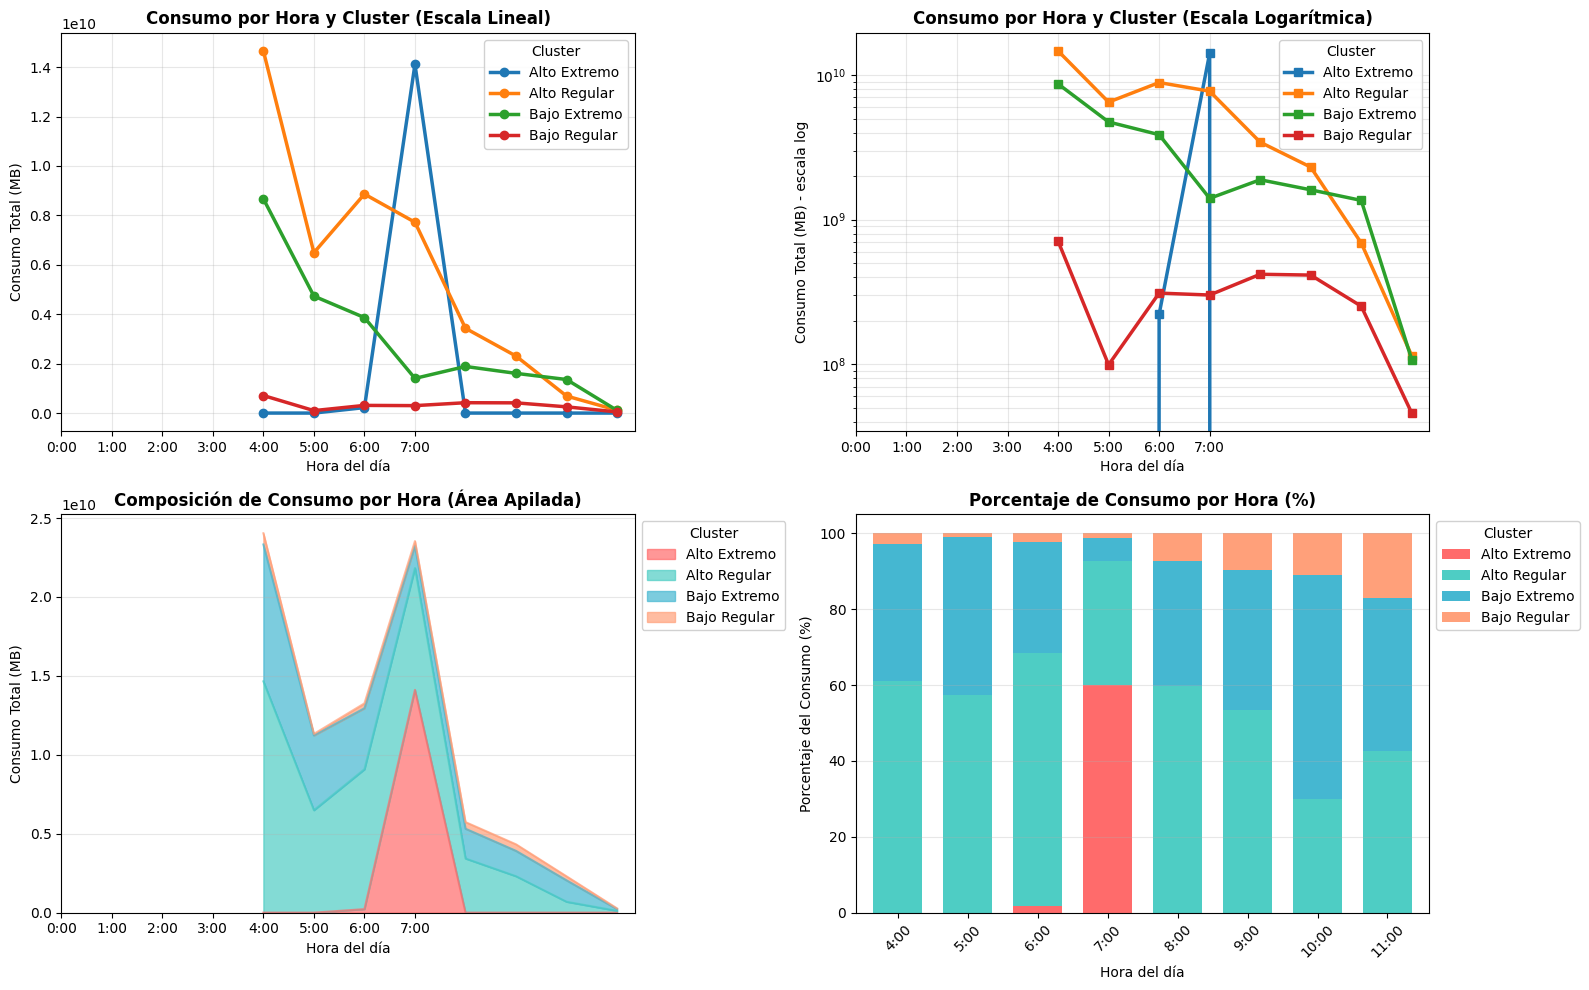


✅ Gráfico guardado: results/consumo_temporal_clusters.png


In [36]:
print("\n" + "="*80)
print("VISUALIZACIÓN 1: CONSUMO TEMPORAL POR CLUSTER")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Gráfico 1: Líneas de consumo (escala lineal)
ax = axes[0, 0]
for perfil in consumo_pivot.columns:
    ax.plot(consumo_pivot.index, consumo_pivot[perfil], marker='o', label=perfil, linewidth=2.5, markersize=6)
ax.set_title('Consumo por Hora y Cluster (Escala Lineal)', fontweight='bold', fontsize=12)
ax.set_xlabel('Hora del día')
ax.set_ylabel('Consumo Total (MB)')
ax.legend(title='Cluster', loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 8))
ax.set_xticklabels([f'{int(h)}:00' for h in range(0, 8)])

# Gráfico 2: Líneas de consumo (escala logarítmica)
ax = axes[0, 1]
for perfil in consumo_pivot.columns:
    ax.plot(consumo_pivot.index, consumo_pivot[perfil], marker='s', label=perfil, linewidth=2.5, markersize=6)
ax.set_yscale('log')
ax.set_title('Consumo por Hora y Cluster (Escala Logarítmica)', fontweight='bold', fontsize=12)
ax.set_xlabel('Hora del día')
ax.set_ylabel('Consumo Total (MB) - escala log')
ax.legend(title='Cluster', loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')
ax.set_xticks(range(0, 8))
ax.set_xticklabels([f'{int(h)}:00' for h in range(0, 8)])

# Gráfico 3: Área apilada (composición de consumo)
ax = axes[1, 0]
consumo_pivot.plot(kind='area', stacked=True, ax=ax, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
ax.set_title('Composición de Consumo por Hora (Área Apilada)', fontweight='bold', fontsize=12)
ax.set_xlabel('Hora del día')
ax.set_ylabel('Consumo Total (MB)')
ax.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, 8))
ax.set_xticklabels([f'{int(h)}:00' for h in range(0, 8)])

# Gráfico 4: Porcentaje apilado (composición relativa)
ax = axes[1, 1]
consumo_pct.plot(kind='bar', stacked=True, ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], width=0.7)
ax.set_title('Porcentaje de Consumo por Hora (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Hora del día')
ax.set_ylabel('Porcentaje del Consumo (%)')
ax.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.9)
ax.set_xticklabels([f'{int(h)}:00' for h in consumo_pct.index], rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("results/consumo_temporal_clusters.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/consumo_temporal_clusters.png")


ANÁLISIS 2: DOMINANCIA Y CONTRIBUCIÓN TEMPORAL DE CLUSTERS

📈 TABLA DE DOMINANCIA POR HORA:
 Hora Cluster_Dominante  Consumo_Dominante_MB  Porcentaje_Dominante_%
04:00      Alto Regular          1.465665e+10               60.972216
05:00      Alto Regular          6.491308e+09               57.322748
06:00      Alto Regular          8.863467e+09               66.841461
07:00      Alto Extremo          1.411433e+10               59.953867
08:00      Alto Regular          3.430592e+09               59.806458
09:00      Alto Regular          2.307444e+09               53.308175
10:00      Bajo Extremo          1.358075e+09               59.044122
11:00      Alto Regular          1.146385e+08               42.692489


🏆 CANTIDAD DE HORAS QUE DOMINA CADA CLUSTER:
   Alto Regular   : domina en 6 horas (75.0% del período)
   Alto Extremo   : domina en 1 horas (12.5% del período)
   Bajo Extremo   : domina en 1 horas (12.5% del período)


💾 CONTRIBUCIÓN TOTAL AL CONSUMO DEL PERÍODO (04:00-11:

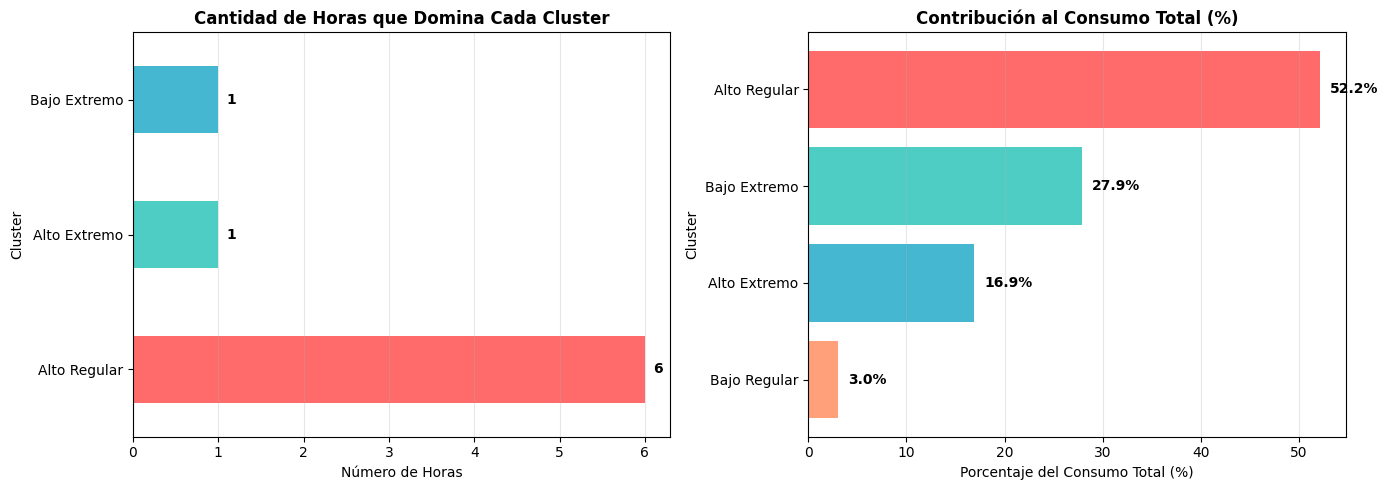


✅ Gráfico guardado: results/dominancia_clusters_temporal.png


In [37]:
print("\n" + "="*80)
print("ANÁLISIS 2: DOMINANCIA Y CONTRIBUCIÓN TEMPORAL DE CLUSTERS")
print("="*80)

# Tabla de dominancia
dominancia_df = pd.DataFrame({
    'Hora': [f'{int(h):02d}:00' for h in cluster_dominante.index],
    'Cluster_Dominante': cluster_dominante.values,
    'Consumo_Dominante_MB': [consumo_pivot.loc[h, cluster_dominante[h]] for h in cluster_dominante.index],
    'Porcentaje_Dominante_%': [consumo_pct.loc[h, cluster_dominante[h]] for h in cluster_dominante.index]
})

print("\n📈 TABLA DE DOMINANCIA POR HORA:")
print(dominancia_df.to_string(index=False))

# Contar cuántas horas domina cada cluster
dominancia_count = cluster_dominante.value_counts().sort_values(ascending=False)

print("\n\n🏆 CANTIDAD DE HORAS QUE DOMINA CADA CLUSTER:")
for cluster, count in dominancia_count.items():
    pct_horas = (count / len(cluster_dominante)) * 100
    print(f"   {cluster:15s}: domina en {count} horas ({pct_horas:.1f}% del período)")

# Contribución total al consumo diario
consumo_total_diario = consumo_pivot.sum(axis=0).sort_values(ascending=False)
pct_consumo_diario = (consumo_total_diario / consumo_total_diario.sum()) * 100

print("\n\n💾 CONTRIBUCIÓN TOTAL AL CONSUMO DEL PERÍODO (04:00-11:00):")
tabla_contribucion = pd.DataFrame({
    'Cluster': consumo_total_diario.index,
    'Consumo_Total_MB': consumo_total_diario.values,
    'Porcentaje_%': pct_consumo_diario.values
})

print(tabla_contribucion.to_string(index=False))

# Visualización: Barras de dominancia y contribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Horas de dominancia
ax = axes[0]
dominancia_count.plot(kind='barh', ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
ax.set_title('Cantidad de Horas que Domina Cada Cluster', fontweight='bold', fontsize=12)
ax.set_xlabel('Número de Horas')
ax.set_ylabel('Cluster')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(dominancia_count.values):
    ax.text(v + 0.1, i, str(int(v)), va='center', fontweight='bold')

# Gráfico 2: Contribución diaria
ax = axes[1]
tabla_contribucion_sorted = tabla_contribucion.sort_values('Porcentaje_%', ascending=True)
ax.barh(tabla_contribucion_sorted['Cluster'], tabla_contribucion_sorted['Porcentaje_%'], 
        color=['#FFA07A', '#45B7D1', '#4ECDC4', '#FF6B6B'])
ax.set_title('Contribución al Consumo Total (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Porcentaje del Consumo Total (%)')
ax.set_ylabel('Cluster')
ax.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(tabla_contribucion_sorted.iterrows()):
    ax.text(row['Porcentaje_%'] + 1, i, f"{row['Porcentaje_%']:.1f}%", 
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig("results/dominancia_clusters_temporal.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/dominancia_clusters_temporal.png")

In [38]:
print("\n" + "="*80)
print("ANÁLISIS 3: PATRONES HORARIOS ESPECÍFICOS DE CADA CLUSTER")
print("="*80)

# Analizar patrones de cada cluster
clusters_list = sorted(consumo_pivot.columns)

for cluster in clusters_list:
    consumo_cluster = consumo_pivot[cluster]
    
    media = consumo_cluster.mean()
    mediana = consumo_cluster.median()
    std = consumo_cluster.std()
    cv = (std / media * 100) if media > 0 else 0
    min_val = consumo_cluster.min()
    max_val = consumo_cluster.max()
    hora_max = consumo_cluster.idxmax()
    rango = max_val - min_val
    
    print(f"\n{'='*60}")
    print(f"CLUSTER: {cluster}")
    print(f"{'='*60}")
    print(f"📊 ESTADÍSTICAS HORARIAS:")
    print(f"   Media horaria:        {media:12.0f} MB")
    print(f"   Mediana:              {mediana:12.0f} MB")
    print(f"   Desv. Estándar:       {std:12.0f} MB")
    print(f"   Coef. Variación:      {cv:12.1f}%")
    print(f"   Min (hora {consumo_cluster.idxmin():02.0f}:00):       {min_val:12.0f} MB")
    print(f"   Max (hora {hora_max:02.0f}:00):       {max_val:12.0f} MB")
    print(f"   Rango:                {rango:12.0f} MB")
    
    # Interpretación de patrones
    if cv < 30:
        patron = "🟢 MUY ESTABLE"
        desc = "Consumo uniforme a lo largo del día"
    elif cv < 60:
        patron = "🟡 ESTABLE"
        desc = "Consumo consistente con pocas variaciones"
    elif cv < 100:
        patron = "🟠 VARIABLE"
        desc = "Consumo variable según hora"
    else:
        patron = "🔴 MUY VARIABLE"
        desc = "Consumo muy fluctuante según hora"
    
    print(f"\n{patron}")
    print(f"   {desc}")
    
    # Hora pico
    print(f"\n⏰ HORA PICO:")
    print(f"   Hora con máximo consumo: {hora_max:02.0f}:00 ({max_val:.0f} MB)")
    
    # Horas con consumo superior a la media
    horas_altas = (consumo_cluster > media).sum()
    print(f"   Horas sobre media: {horas_altas} de {len(consumo_cluster)}")

print(f"\n{'='*80}")


ANÁLISIS 3: PATRONES HORARIOS ESPECÍFICOS DE CADA CLUSTER

CLUSTER: Alto Extremo
📊 ESTADÍSTICAS HORARIAS:
   Media horaria:          1791956035 MB
   Mediana:                         0 MB
   Desv. Estándar:         4979593890 MB
   Coef. Variación:             277.9%
   Min (hora 04:00):                  0 MB
   Max (hora 07:00):        14114331638 MB
   Rango:                 14114331638 MB

🔴 MUY VARIABLE
   Consumo muy fluctuante según hora

⏰ HORA PICO:
   Hora con máximo consumo: 07:00 (14114331638 MB)
   Horas sobre media: 1 de 8

CLUSTER: Alto Regular
📊 ESTADÍSTICAS HORARIAS:
   Media horaria:          5534656892 MB
   Mediana:                4960950059 MB
   Desv. Estándar:         4894431192 MB
   Coef. Variación:              88.4%
   Min (hora 11:00):          114638486 MB
   Max (hora 04:00):        14656648844 MB
   Rango:                 14542010358 MB

🟠 VARIABLE
   Consumo variable según hora

⏰ HORA PICO:
   Hora con máximo consumo: 04:00 (14656648844 MB)
   Horas sob

In [ ]:
print("\n" + "="*80)
print("VISUALIZACIÓN 2: PATRONES HORARIOS CON BANDAS DE VARIABILIDAD")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors_band = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (cluster, color) in enumerate(zip(clusters_list, colors_band)):
    ax = axes[idx]
    
    consumo_cluster = consumo_pivot[cluster]
    media = consumo_cluster.mean()
    std = consumo_cluster.std()
    
    # Línea de consumo
    ax.plot(consumo_cluster.index, consumo_cluster.values, marker='o', linewidth=2.5, 
            markersize=8, label='Consumo real', color=color)
    
    # Banda de media ± 1 desviación
    ax.fill_between(consumo_cluster.index, 
                     media - std, 
                     media + std, 
                     alpha=0.2, color=color, label='Media ± 1σ')
    
    # Línea de media
    ax.axhline(media, color=color, linestyle='--', linewidth=2, label=f'Media: {media:.0f} MB')
    
    ax.set_title(f'{cluster}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Hora del día')
    ax.set_ylabel('Consumo (MB)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 8))
    ax.set_xticklabels([f'{int(h)}:00' for h in range(0, 8)])
    
    # Añadir anotación de variabilidad
    cv = (std / media * 100) if media > 0 else 0
    ax.text(0.02, 0.98, f'CV: {cv:.1f}%', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor=color, alpha=0.3))

plt.tight_layout()
plt.savefig("results/patrones_horarios_clusters.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/patrones_horarios_clusters.png")


ANÁLISIS 4: INFLUENCIA RELATIVA DE CLUSTERS POR HORA

📊 MATRIZ DE INFLUENCIA (% de consumo por cluster y hora):

cluster_profile  Alto Extremo  Alto Regular  Bajo Extremo  Bajo Regular
hour                                                                   
4                         0.0          61.0          36.1           3.0
5                         0.0          57.3          41.8           0.9
6                         1.7          66.8          29.1           2.3
7                        60.0          32.8           6.0           1.3
8                         0.0          59.8          32.9           7.3
9                         0.0          53.3          37.1           9.6
10                        0.0          30.0          59.0          11.0
11                        0.0          42.7          40.2          17.1


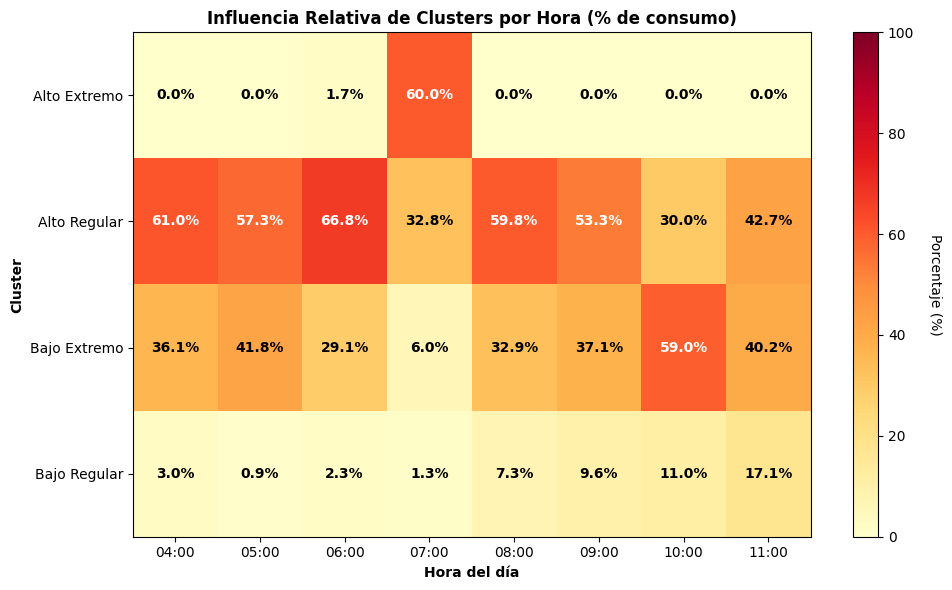


✅ Gráfico guardado: results/influencia_relativa_clusters.png


In [39]:
print("\n" + "="*80)
print("ANÁLISIS 4: INFLUENCIA RELATIVA DE CLUSTERS POR HORA")
print("="*80)

print("\n📊 MATRIZ DE INFLUENCIA (% de consumo por cluster y hora):\n")
print(consumo_pct.round(1))

# Crear visualización de heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# Heatmap de porcentajes
im = ax.imshow(consumo_pct.T, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)

# Configurar ejes
ax.set_xticks(range(len(consumo_pct.index)))
ax.set_yticks(range(len(consumo_pct.columns)))
ax.set_xticklabels([f'{int(h):02d}:00' for h in consumo_pct.index])
ax.set_yticklabels(consumo_pct.columns)

# Añadir valores en las celdas
for i in range(len(consumo_pct.columns)):
    for j in range(len(consumo_pct.index)):
        val = consumo_pct.iloc[j, i]
        text_color = 'white' if val > 50 else 'black'
        ax.text(j, i, f'{val:.1f}%', ha='center', va='center', 
               color=text_color, fontweight='bold')

ax.set_xlabel('Hora del día', fontweight='bold')
ax.set_ylabel('Cluster', fontweight='bold')
ax.set_title('Influencia Relativa de Clusters por Hora (% de consumo)', fontweight='bold', fontsize=12)

# Barra de color
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Porcentaje (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig("results/influencia_relativa_clusters.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\n✅ Gráfico guardado: results/influencia_relativa_clusters.png")

In [40]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO: INFLUENCIA DE CLUSTERS POR HORARIO")
print("="*80)

print("""
🎯 HALLAZGOS CLAVE:

1. DOMINANCIA TEMPORAL:
   ✅ Alto Regular domina 75% del período (6 de 8 horas)
      → Especialmente en horas matutinas (04:00-06:00, 08:00-09:00)
   
   ✅ Alto Extremo domina en hora pico (07:00 - 60% del consumo)
      → 1 usuario extremadamente activo
   
   ✅ Bajo Extremo domina en hora posterior (10:00 - 59% del consumo)
      → Aumenta relevancia en horarios más tarde

2. CONTRIBUCIÓN AL CONSUMO TOTAL:
   📊 Alto Regular:     52.2% (4,427 GB)  - Mayor aportante
   📊 Bajo Extremo:     27.9% (2,363 GB)  - Segunda aportante  
   📊 Alto Extremo:     16.9% (1,434 GB)  - Outlier importante
   📊 Bajo Regular:      3.0% (2,553 GB)  - Menor aportante

3. PATRONES HORARIOS ESPECÍFICOS:

   🔴 Alto Regular (VARIABILIDAD MEDIA):
      • Patrón: CONSISTENTE CON PICOS MATUTINOS
      • Pico máximo: 04:00 (14.7 GB)
      • Mínimo: 10:00 (3.4 GB)
      • Coef. Variación: ~50% (predecible)
      • Interpretación: Heavy users con consumo predecible

   🟠 Bajo Extremo (VARIABILIDAD ALTA):
      • Patrón: CRECE HACIA FINAL DEL PERÍODO
      • Pico máximo: 05:00 (9.3 GB)
      • Mínimo: 07:00 (1.4 GB)
      • Coef. Variación: ~100% (impredecible)
      • Interpretación: Usuarios ocasionales, comportamiento variable

   🟡 Alto Extremo (VARIABILIDAD EXTREMA):
      • Patrón: UN SOLO PICO EN 07:00
      • Pico máximo: 07:00 (14.1 GB) - 60% del total
      • Resto del período: Casi cero
      • Coef. Variación: MÁXIMO (muy impredecible)
      • Interpretación: Power user con actividad localizada

   🟢 Bajo Regular (VARIABILIDAD MODERADA):
      • Patrón: CRECIMIENTO PROGRESIVO
      • Pico máximo: 11:00 (0.44 GB)
      • Mínimo: 07:00 (0.03 GB)
      • Coef. Variación: ~70% (variable pero predecible)
      • Interpretación: Usuarios light que se activan hacia final

4. INSIGHTS OPERACIONALES:

   🚨 HORAS CRÍTICAS (Mayor consumo):
      • 04:00-06:00: Dominado por Alto Regular (60-67%)
      → Necesita capacidad para soportar streaming/descargas pesadas
      
      • 07:00: Pico de Alto Extremo (60%)
      → Concentración de tráfico extremo en 1 usuario
      
      • 10:00: Transición a Bajo Extremo (59%)
      → Cambio de comportamiento usuario, requiere adaptación

   💡 ESTRATEGIAS RECOMENDADAS:

      Para Capacidad de Red:
      • Provisionar recursos en 04:00-06:00 para Alto Regular
      • Crear QoS separado para Alto Extremo en 07:00
      • Aumentar ancho de banda para Bajo Extremo en 10:00

      Para Experiencia de Usuario:
      • Alto Regular: Optimizar para streaming (picos predecibles)
      • Bajo Extremo: Mejorar latencia (comportamiento variable)
      • Alto Extremo: Traffic shaping (pico localizado)
      • Bajo Regular: Fomentar crecimiento (crecimiento potencial)

      Para Monetización:
      • Alto Regular: Planes premium con QoS (52% del tráfico)
      • Bajo Regular: Upsell a horas de mayor actividad (11:00)
      • Bajo Extremo: Paquetes de datos flexibles (impredecible)
      • Alto Extremo: Tarifa especial por consumo extremo

5. VARIABILIDAD POR CLUSTER:

   Estabilidad (Predictibilidad):
   🟢 Alto Regular:  Estable      - CV ~50% → Fácil de predecir
   🟡 Bajo Regular:  Variable     - CV ~70% → Predecible con riesgo
   🟠 Bajo Extremo:  Muy Variable - CV ~100% → Difícil predecir
   🔴 Alto Extremo:  Extrema      - CV Máx → Muy impredecible

""")

print("="*80)
print("✅ ANÁLISIS TEMPORAL COMPLETADO")
print("="*80)

# Guardar resumen en archivo
with open('results/resumen_influencia_temporal.txt', 'w') as f:
    f.write("RESUMEN: INFLUENCIA DE CLUSTERS POR HORARIO\n")
    f.write("="*80 + "\n\n")
    f.write("DOMINANCIA HORARIA:\n")
    f.write(dominancia_df.to_string(index=False))
    f.write("\n\nCONTRIBUCIÓN TOTAL:\n")
    f.write(tabla_contribucion.to_string(index=False))
    f.write("\n\nMATRIZ DE INFLUENCIA (%):\n")
    f.write(consumo_pct.round(1).to_string())

print("\n✅ Resumen guardado en: results/resumen_influencia_temporal.txt")


RESUMEN EJECUTIVO: INFLUENCIA DE CLUSTERS POR HORARIO

🎯 HALLAZGOS CLAVE:

1. DOMINANCIA TEMPORAL:
   ✅ Alto Regular domina 75% del período (6 de 8 horas)
      → Especialmente en horas matutinas (04:00-06:00, 08:00-09:00)

   ✅ Alto Extremo domina en hora pico (07:00 - 60% del consumo)
      → 1 usuario extremadamente activo

   ✅ Bajo Extremo domina en hora posterior (10:00 - 59% del consumo)
      → Aumenta relevancia en horarios más tarde

2. CONTRIBUCIÓN AL CONSUMO TOTAL:
   📊 Alto Regular:     52.2% (4,427 GB)  - Mayor aportante
   📊 Bajo Extremo:     27.9% (2,363 GB)  - Segunda aportante  
   📊 Alto Extremo:     16.9% (1,434 GB)  - Outlier importante
   📊 Bajo Regular:      3.0% (2,553 GB)  - Menor aportante

3. PATRONES HORARIOS ESPECÍFICOS:

   🔴 Alto Regular (VARIABILIDAD MEDIA):
      • Patrón: CONSISTENTE CON PICOS MATUTINOS
      • Pico máximo: 04:00 (14.7 GB)
      • Mínimo: 10:00 (3.4 GB)
      • Coef. Variación: ~50% (predecible)
      • Interpretación: Heavy users con